# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

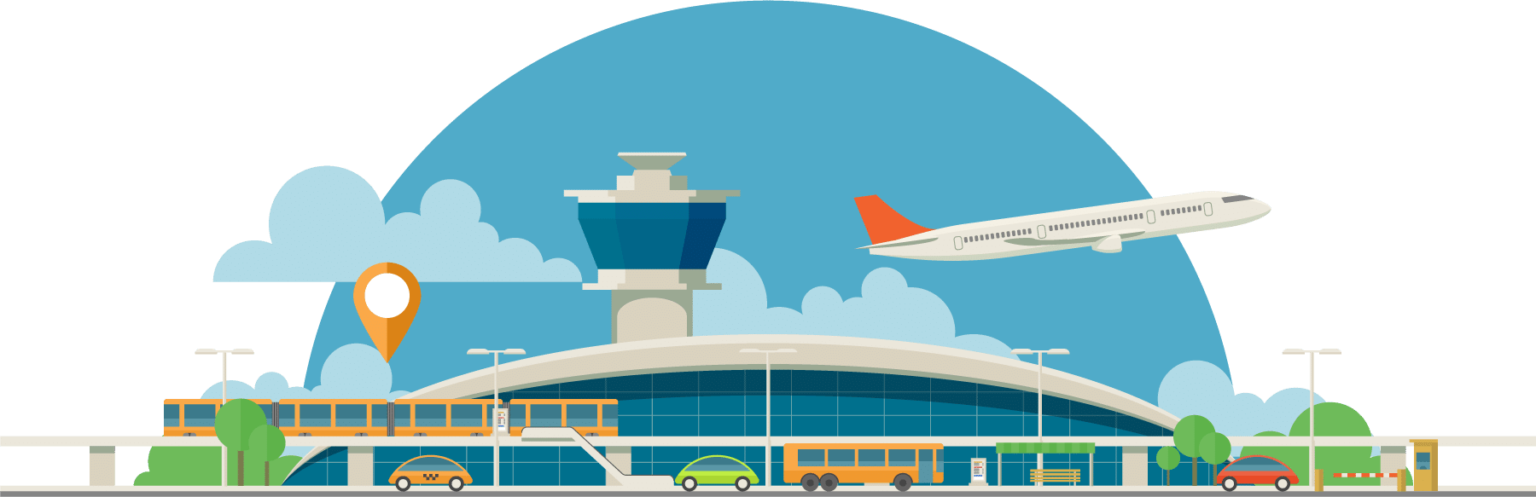

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d4b59a2f751b9d4c3611f8d0a17e5efc3c6efb1c1e6f5cbed9c6dc0f4784a9f0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2024-01-20 07:40:24--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2024-01-20 07:40:25 (1.27 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно.

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

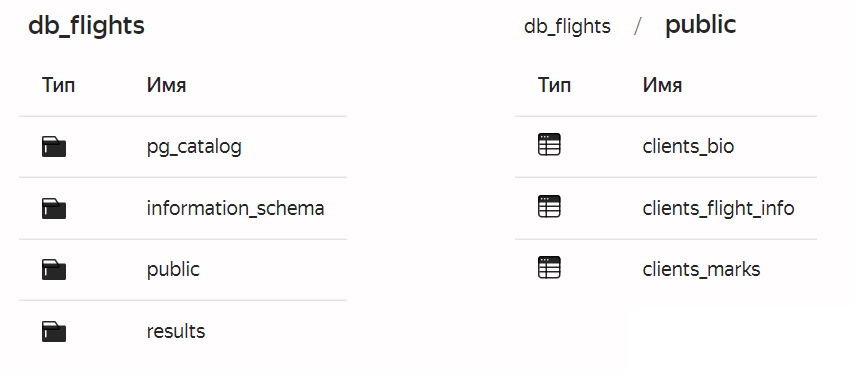

In [4]:
conn = psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
                        port=6432,
                        sslmode='verify-full',
                        dbname='db_flights',
                        user='mlhs_student',
                        password='mlhs_student',
                        target_session_attrs='read-write')
cur = conn.cursor()

In [6]:
query = "SELECT * FROM clients_bio JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id JOIN clients_marks ON clients_bio.id = clients_marks.id;"
df = pd.read_sql_query(query, conn)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [7]:
df = df.loc[:,~df.columns.duplicated()].copy()
df.sort_values(by='id', inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['id'], inplace=True)

In [8]:
df

gender   age      Customer Type   Type of Travel     class  \
0         Male  48.0  disloyal Customer  Business travel  Business   
1       Female  35.0     Loyal Customer  Business travel  Business   
2         Male  41.0     Loyal Customer  Business travel  Business   
3         Male  50.0     Loyal Customer  Business travel  Business   
4       Female  49.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129544    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   
129545    Male  41.0     Loyal Customer  Personal Travel  Eco Plus   
129546    Male  42.0     Loyal Customer  Personal Travel  Eco Plus   
129547    Male  50.0     Loyal Customer  Personal Travel  Eco Plus   
129548  Female  20.0     Loyal Customer  Personal Travel  Eco Plus   

       Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
0                821.0                        2.0                      5.0   
1                821.0                       26.0                     39.0   
2                853.0                        0.0                      0.0   
3               1905.0                        0.0                      0.0   
4               3470.0                        0.0                      1.0   
...                ...                        ...                      ...   
129544           447.0                        2.0                      3.0   
129545           308.0                        0.0                      0.0   
129546           337.0                        6.0                     14.0   
129547           337.0                       31.0                     22.0   
129548           337.0                        0.0                      0.0   

       Inflight wifi service Departure/Arrival time convenient  ...  \
0                        3.0                               3.0  ...   
1                        2.0                               2.0  ...   
2                        4.0                               4.0  ...   
3                        2.0                               2.0  ...   
4                        3.0                               3.0  ...   
...                      ...                               ...  ...   
129544                   4.0                               4.0  ...   
129545                   3.0                               5.0  ...   
129546                   2.0                               5.0  ...   
129547                   5.0                               4.0  ...   
129548                   3.0                               1.0  ...   

       Online boarding Seat comfort Inflight entertainment On-board service  \
0                  3.0          5.0                    5.0              3.0   
1                  5.0          4.0                    5.0              5.0   
2                  5.0          5.0                    3.0              3.0   
3                  4.0          5.0                    5.0              5.0   
4                  5.0          4.0                    3.0              3.0   
...                ...          ...                    ...              ...   
129544             4.0          1.0                    4.0              5.0   
129545             3.0          2.0                    2.0              5.0   
129546             2.0          3.0                    3.0              3.0   
129547             4.0          4.0                    3.0              4.0   
129548             3.0          2.0                    2.0              4.0   

       Leg room service Baggage handling Checkin service Inflight service  \
0                   2.0              5.0             4.0              5.0   
1                   5.0              5.0             3.0              5.0   
2                   3.0              3.0             4.0              3.0   
3                   5.0              5.0             3.0              5.0   
4                   4.0              3.0   

In [9]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [10]:
num_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness', 'Ease of Online booking','Gate location', 'Food and drink']
for col in num_cols:
  df[col] = df[col].astype(float)

In [11]:
missing_cols = []
for col in df.columns:
  missing_values = df[col].isnull().sum()
  if missing_values > 0:
    missing_cols.append(df[col].name)
  print(df[col].name + ": " + str(missing_values))

gender: 0
age: 315
Customer Type: 0
Type of Travel: 0
class: 0
Flight Distance: 94
Departure Delay in Minutes: 107
Arrival Delay in Minutes: 507
Inflight wifi service: 44
Departure/Arrival time convenient: 49
Ease of Online booking: 43
Gate location: 37
Food and drink: 50
Online boarding: 46
Seat comfort: 47
Inflight entertainment: 45
On-board service: 44
Leg room service: 46
Baggage handling: 48
Checkin service: 42
Inflight service: 63
cleanliness: 37
satisfaction: 0


In [12]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [13]:
df.describe(include='object')

gender   Customer Type   Type of Travel     class  \
count   129549          129549           129549    129549   
unique       2               3                3         4   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

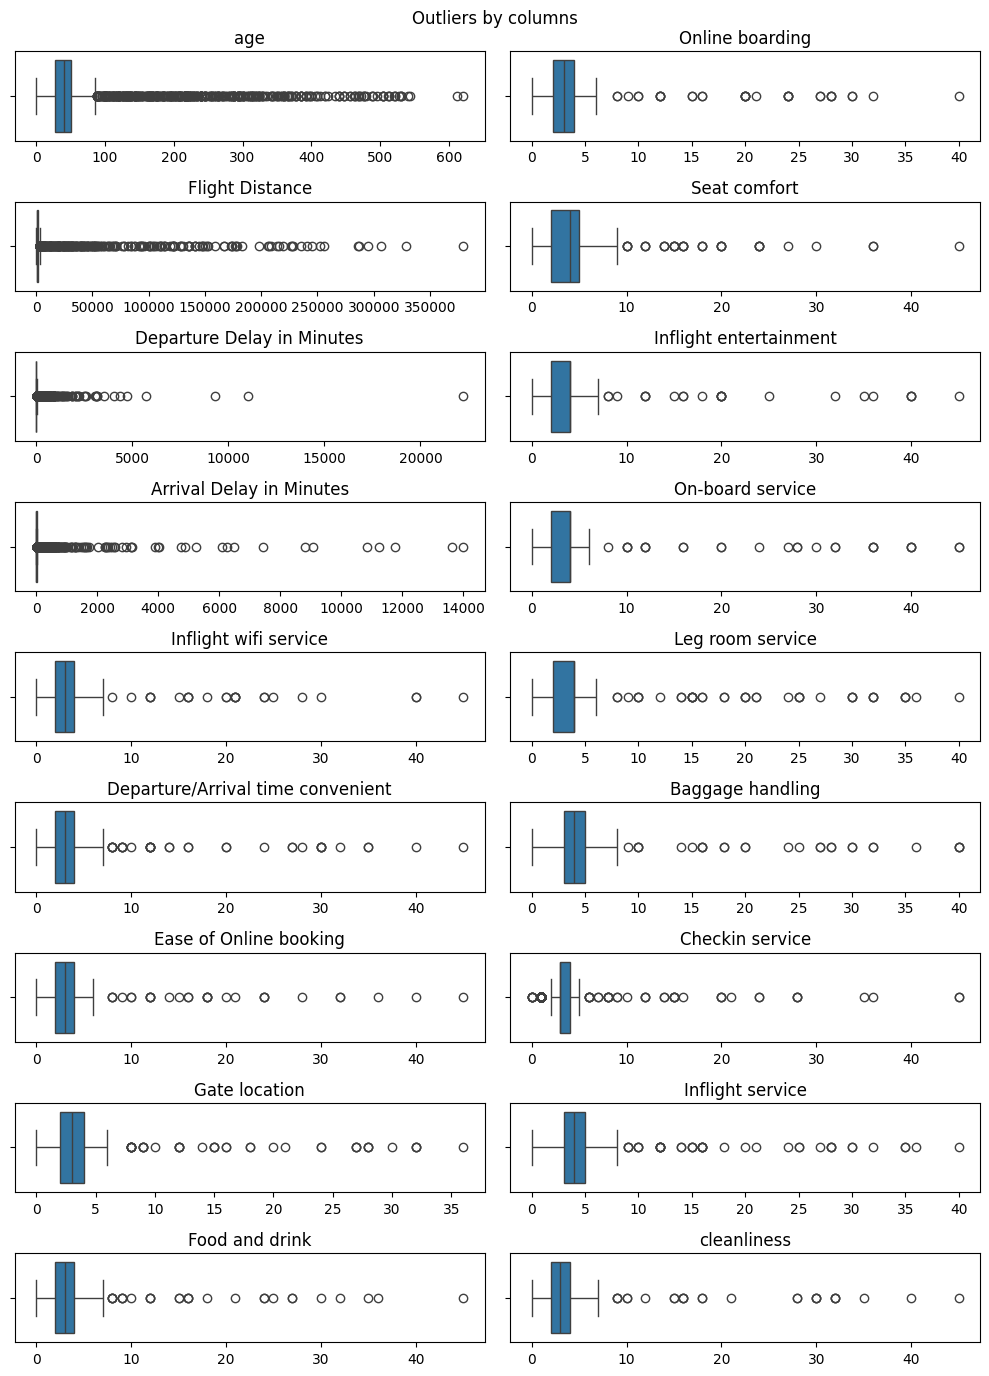

In [14]:
from math import ceil
from itertools import product

df_float = df.select_dtypes('float64')

len_col = len(df_float.columns)

fig, axes = plt.subplots(ceil(len_col / 2), 2, figsize=(10, 14))
fig.suptitle('Outliers by columns')

for (x, y), col in zip(product(range(2), range(ceil(len_col / 2))), df_float.columns):
    axes[y, x].set_title(col)
    plot = sns.boxplot(ax=axes[y, x], x=df_float[col])
    plot.set(xlabel=None)

fig.tight_layout()

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

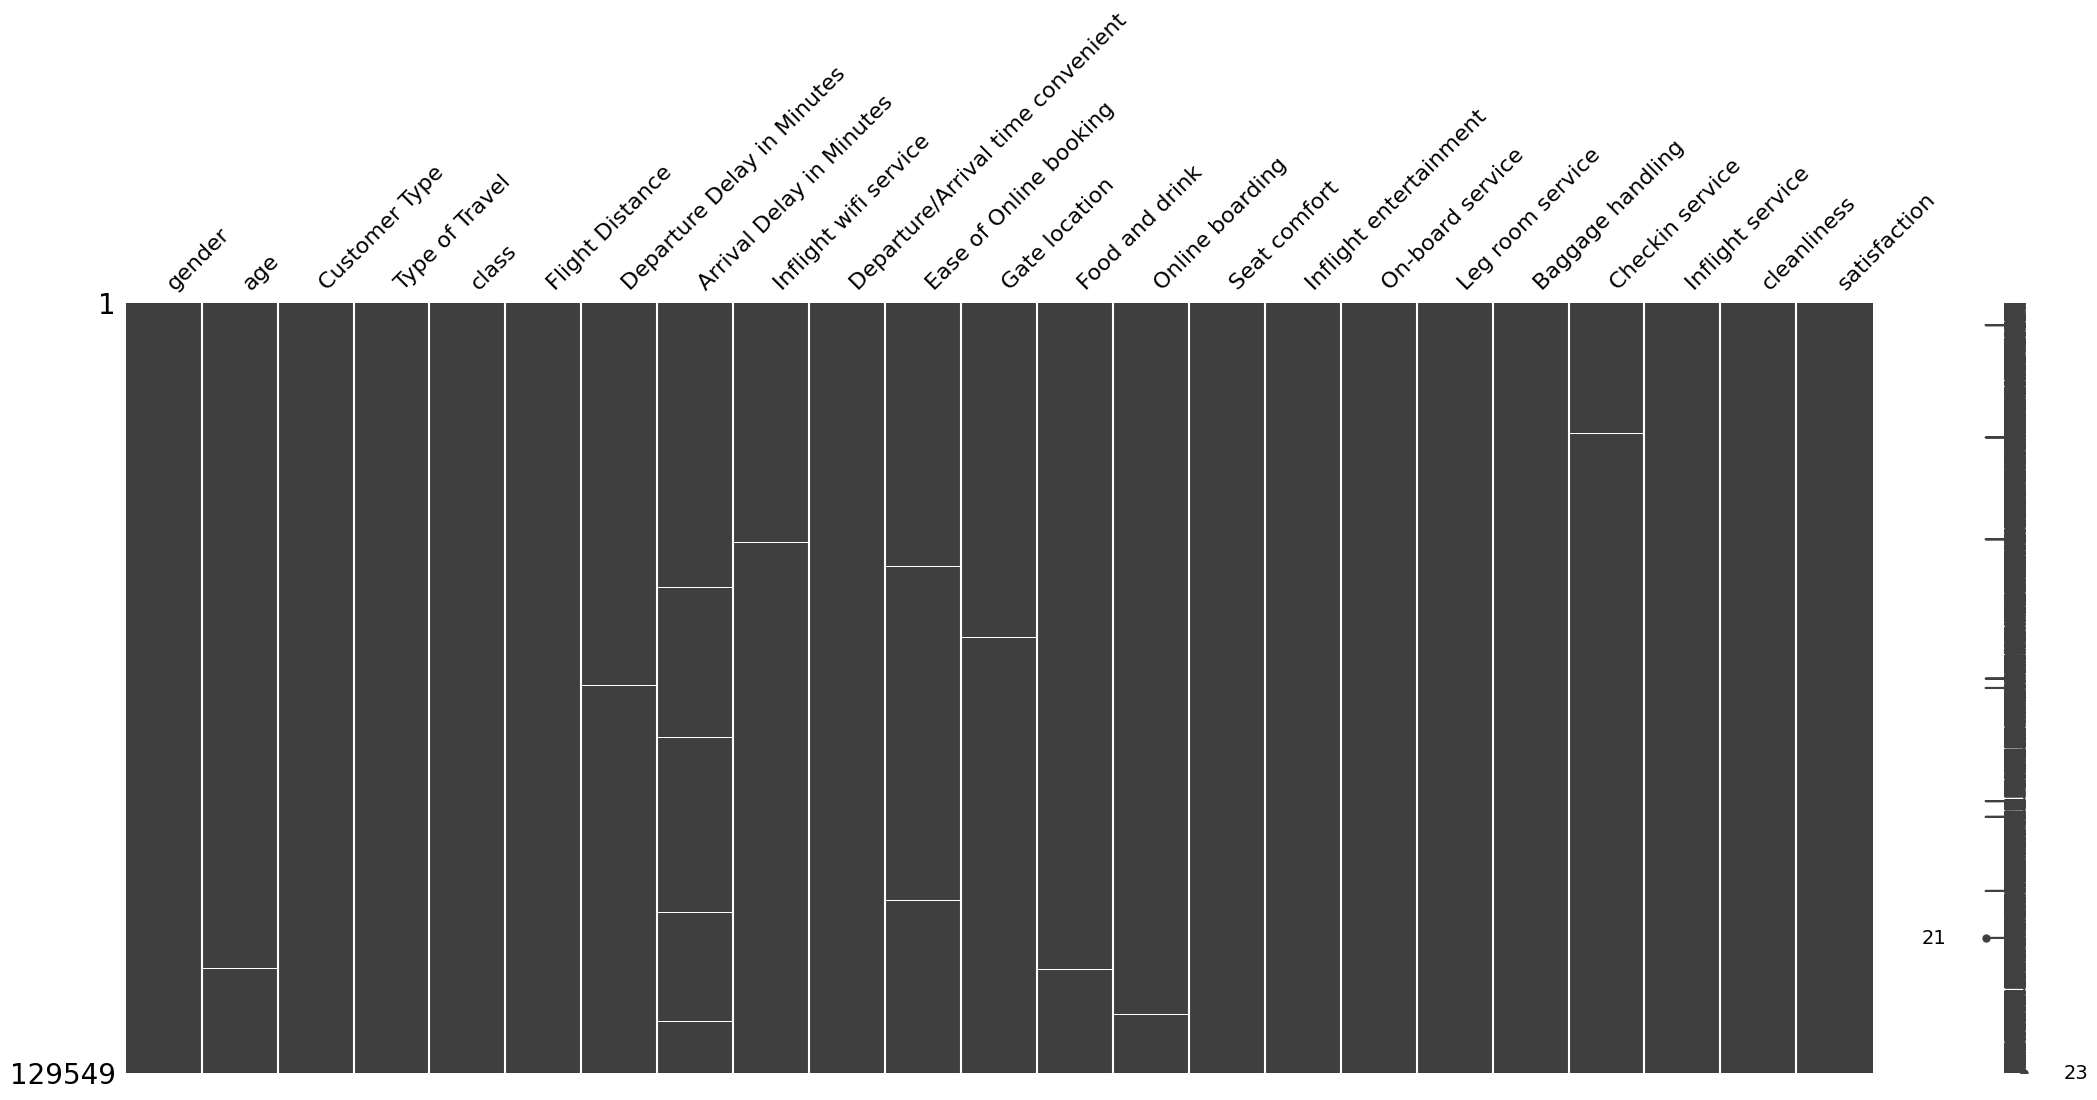

In [15]:
# your code below
missingno.matrix(df)

FixedFormatter should only be used together with FixedLocator


<Axes: >

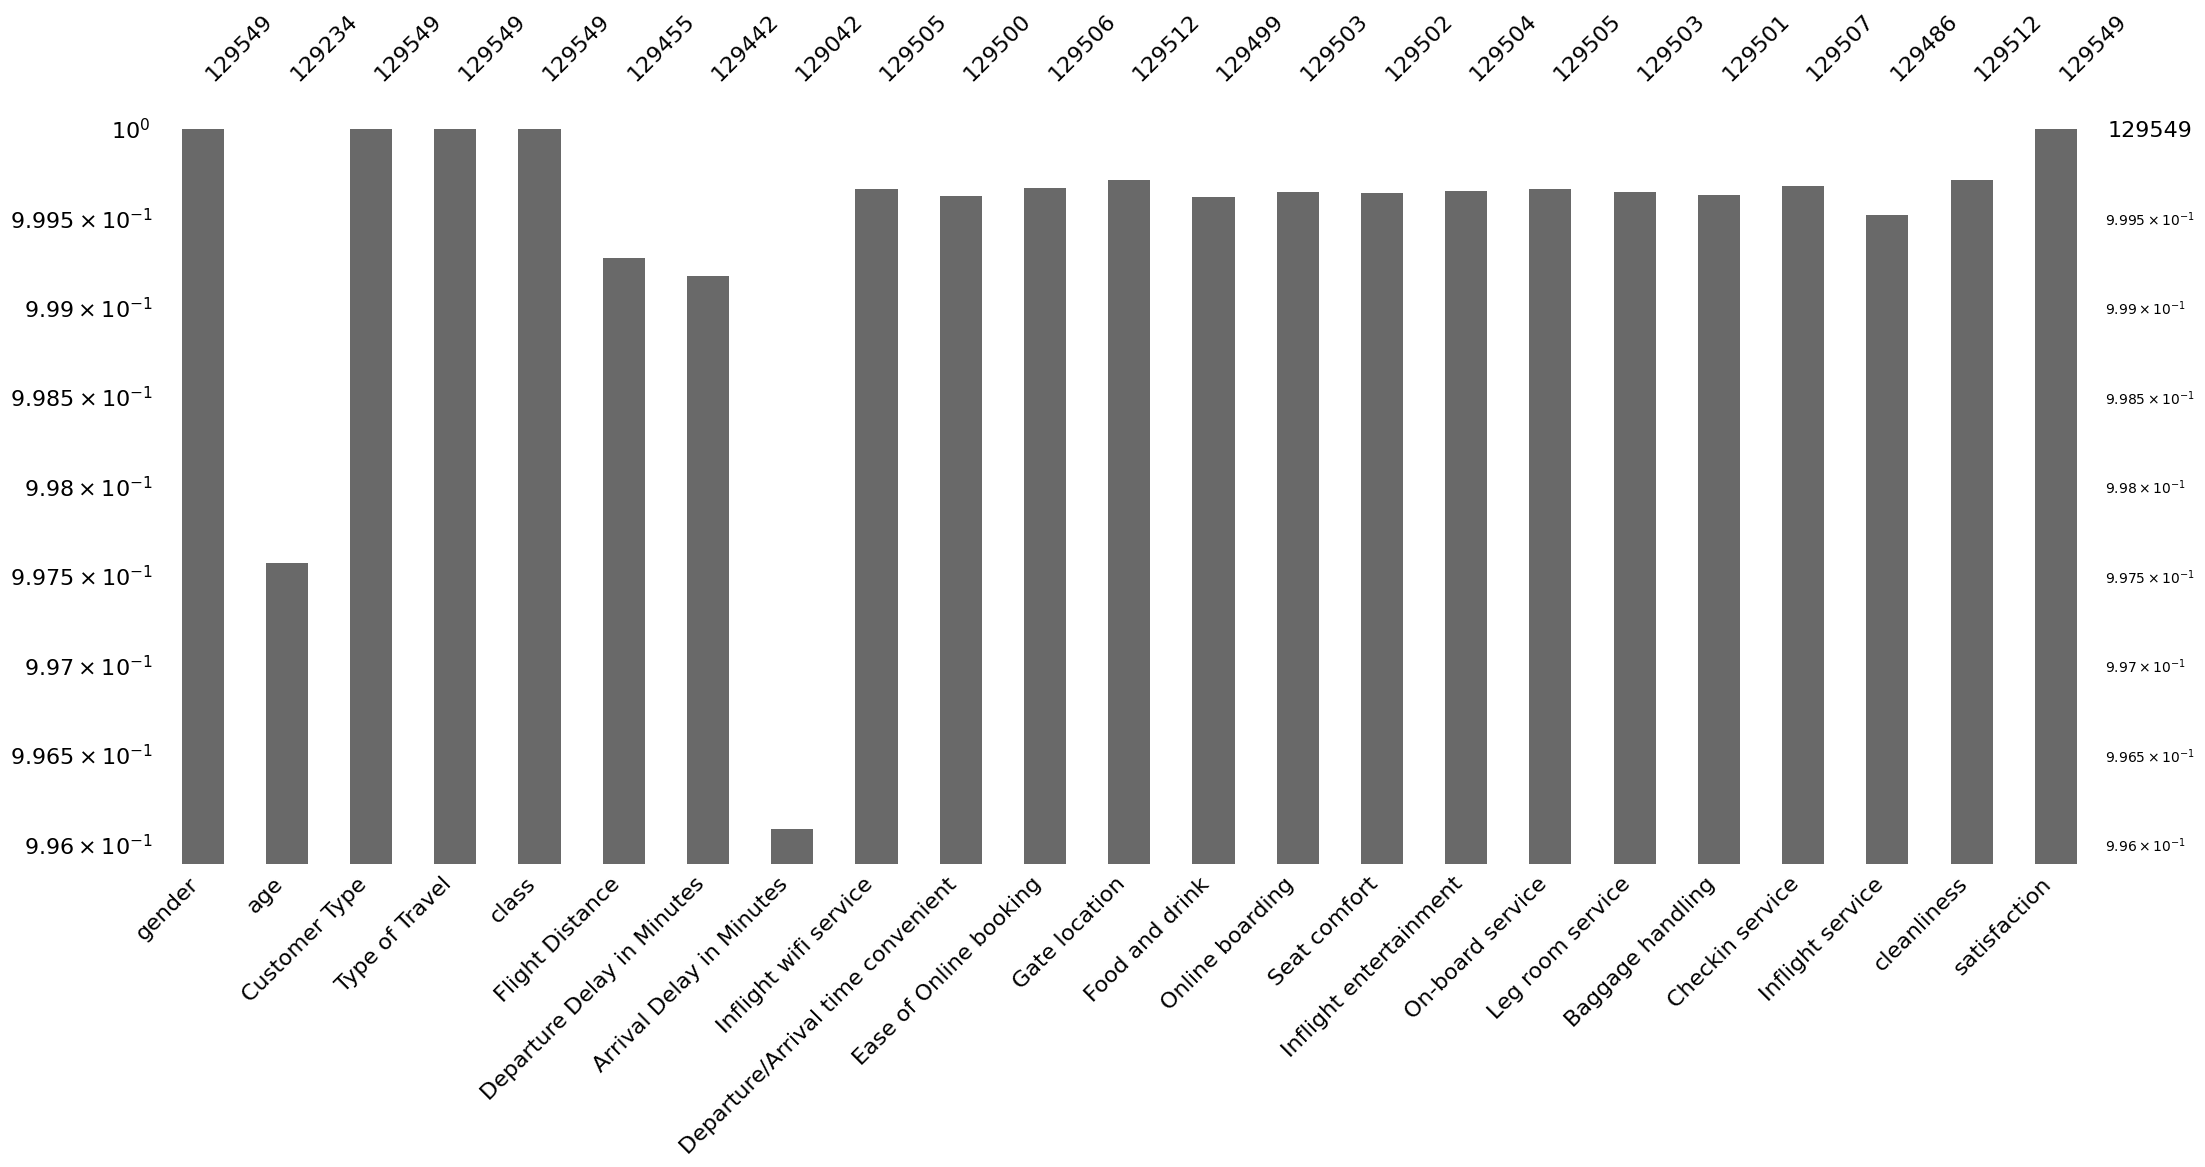

In [16]:
# your code below
missingno.bar(df, log = True)

In [17]:
df_obj = df.select_dtypes('object')
for col in df_obj.columns:
    display(df_obj[col].value_counts())

Female    65726
Male      63823
Name: gender, dtype: int64

Loyal Customer       105763
disloyal Customer     23709
nan                      77
Name: Customer Type, dtype: int64

Business travel    89405
Personal Travel    40043
nan                  101
Name: Type of Travel, dtype: int64

Business    61939
Eco         58115
Eco Plus     9379
nan           116
Name: class, dtype: int64

neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: satisfaction, dtype: int64

In [18]:
df_obj = df_obj.replace(['nan', '-'], np.nan)
df[df_obj.columns] = df_obj

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [19]:
df_train = df[df.satisfaction.notna()]
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  48.0  disloyal Customer  Business travel  Business   
1       Female  35.0     Loyal Customer  Business travel  Business   
2         Male  41.0     Loyal Customer  Business travel  Business   
3         Male  50.0     Loyal Customer  Business travel  Business   
4       Female  49.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel  Eco Plus   
129543  Female  55.0     Loyal Customer  Personal Travel  Eco Plus   
129546    Male  42.0     Loyal Customer  Personal Travel  Eco Plus   
129547    Male  50.0     Loyal Customer  Personal Travel  Eco Plus   
129548  Female  20.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                 821.0                         2.0                       5.0   
1                 821.0                        26.0                      39.0   
2                 853.0                         0.0                       0.0   
3                1905.0                         0.0                       0.0   
4                3470.0                         0.0                       1.0   
...                 ...                         ...                       ...   
129542            337.0                         0.0                       0.0   
129543            308.0                         0.0                       0.0   
129546            337.0                         6.0                      14.0   
129547            337.0                        31.0                      22.0   
129548            337.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         4.0                                4.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    4.0                                2.0  ...   
129543                    3.0                                4.0  ...   
129546                    2.0                                5.0  ...   
129547                    5.0                                4.0  ...   
129548                    3.0                                1.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   3.0           5.0                     5.0   
1                   5.0           4.0                     5.0   
2                   5.0           5.0                     3.0   
3                   4.0           5.0                     5.0   
4                   5.0           4.0                     3.0   
...                 ...           ...                     ...   
129542              4.0           3.0                     3.0   
129543              4.0           3.0                     4.0   
129546              2.0           3.0                     3.0   
129547              4.0           4.0                     3.0   
129548              3.0           2.0                     2.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    3.0               2.0               5.0              4.0   
1                    5.0               5.0               5.0              3.0   
2                    3.0               3.0               3.0              4.0   
3                    5.0               5.0               5.0              3.0   
4                    3.0               4.0               3.0              3.0   
...                  ...               ...        

In [20]:
assert df_train.shape == (103_644, 23)

In [21]:
df_test = df[df.satisfaction.isna()].drop('satisfaction', axis=1)
df_test

gender   age      Customer Type   Type of Travel     class  \
16      Female  48.0     Loyal Customer  Personal Travel       Eco   
19      Female  42.0     Loyal Customer  Personal Travel       Eco   
34        Male  39.0     Loyal Customer  Business travel  Business   
43        Male  51.0     Loyal Customer  Business travel  Business   
48        Male  20.0  disloyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
129515  Female  16.0     Loyal Customer  Personal Travel       Eco   
129536    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129540  Female  32.0     Loyal Customer  Business travel  Eco Plus   
129544    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   
129545    Male  41.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
16                821.0                         0.0                       0.0   
19                821.0                         4.0                       0.0   
34               1672.0                        23.0                      17.0   
43               2077.0                         0.0                       1.0   
48                108.0                         0.0                      29.0   
...                 ...                         ...                       ...   
129515            337.0                         0.0                       0.0   
129536            447.0                         0.0                       0.0   
129540            337.0                         0.0                       1.0   
129544            447.0                         2.0                       3.0   
129545            308.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
16                        2.0                                3.0  ...   
19                        3.0                                3.0  ...   
34                        2.0                                2.0  ...   
43                        4.0                                1.0  ...   
48                        4.0                                5.0  ...   
...                       ...                                ...  ...   
129515                    0.0                                4.0  ...   
129536                    3.0                                4.0  ...   
129540                    4.0                                2.0  ...   
129544                    4.0                                4.0  ...   
129545                    3.0                                5.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
16                 1.0              5.0           1.0                     5.0   
19                 1.0              3.0           4.0                     1.0   
34                 5.0              4.0           5.0                     3.0   
43                 2.0              5.0           5.0                     5.0   
48                 5.0              4.0           3.0                     5.0   
...                ...              ...           ...                     ...   
129515             3.0              0.0           3.0                     3.0   
129536             4.0              3.0           4.0                     4.0   
129540             4.0              4.0           4.0                     4.0   
129544             4.0              4.0           1.0                     4.0   
129545             2.0              3.0           2.0                     2.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
16                   5.0               2.0               5.0              5.0   
19                   1.0               3.0               1.0              3.0   
34                   3.0               4.0               5.0              5.0   
43                  

In [22]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [23]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [24]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые.

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [25]:
# your code below
modes = X_train.mode().iloc[0]

X_train = X_train.fillna(modes)
X_val = X_val.fillna(modes)
df_test = df_test.fillna(modes)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [26]:
X_train.describe()


age  Flight Distance  Departure Delay in Minutes  \
count  72365.000000     72504.000000                72485.000000   
mean      40.086437      1338.857484                   15.656619   
std       20.381475      4840.109431                   67.858773   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       842.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      612.000000    328510.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72278.000000           72530.000000   
mean                  16.442763               2.735530   
std                  100.730070               1.367095   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72519.000000            72528.000000   
mean                            3.063156                2.760672   
std                             1.556411                1.416502   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               36.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72532.000000    72523.000000     72527.000000  72514.000000   
mean        2.981787        3.207838         3.259586      3.444052   
std         1.302731        1.357369         1.393479      1.344650   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       45.000000        40.000000     36.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72523.000000      72525.000000      72524.000000   
mean                 3.362423          3.382765          3.354862   
std                  1.368890          1.335074          1.371945   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72528.000000     72527.000000      72518.000000  72528.000000  
mean           3.633659         3.311429          3.644226      3.289474  
std            1.235035         1.312034          1.215679      1.345514  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [27]:
X_train.describe(include='object')

gender   Customer Type   Type of Travel     class
count    72550           72500            72496     72485
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36738           59314            49992     34574

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

**Разброс возраста (age):** средний возраст около 40 лет со стандартным отклонением около 20 лет. Максимальный возраст 544 года явно является выбросом, так как  это невозможно.

 **Дистанция полета (Flight Distance):** существенный разброс значений с максимальным значением в 379620, это может быть ошибка меры или просто ошибка, так как нереалистичное значение.

**Задержки (Departure Delay in Minutes, Arrival Delay in Minutes):** оба признака имеют высокие максимальные значения (9282 и 11760 минут соответственно), что также указывает на выбросы или ошибки в данных. Средние значения и стандартные отклонения также довольно высоки, что может свидетельствовать о широком распределении задержек.


**Оценки услуг (Inflight wifi service до cleanliness):** это рейтинговые данные. Максимальные значения в этих столбцах (например, 45) выходят за пределы обычных рейтинговых шкал (например, 1-5), что указывает на возможные ошибки или выбросы.

Для большинства признаков медиана не сильно отличается от среднего значения, что может указывать на относительную симметричность распределения данных.

В целом, данные требуют дополнительной очистки, особенно для исправления или удаления выбросов.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [28]:
quantile = X_train.quantile(0.996, numeric_only=True)
X_train = X_train[~(X_train[quantile.index].gt(quantile.values, axis='columns').any(axis=1))]
y_train_new = y_train.loc[X_train.index]

In [29]:
X_val = X_val[~(X_val[quantile.index].gt(quantile.values, axis='columns').any(axis=1))]
y_val_new = y_val.loc[X_val_1.index]

In [30]:
X_val

gender   age      Customer Type   Type of Travel     class  \
24079     Male  49.0     Loyal Customer  Business travel  Business   
73769     Male  70.0     Loyal Customer  Business travel  Business   
97148     Male  40.0     Loyal Customer  Personal Travel       Eco   
34093   Female  25.0     Loyal Customer  Business travel  Business   
52042     Male  37.0     Loyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
108369  Female  47.0     Loyal Customer  Business travel  Business   
123897    Male  50.0     Loyal Customer  Business travel  Business   
42623   Female  55.0     Loyal Customer  Personal Travel       Eco   
121603  Female  25.0  disloyal Customer  Business travel  Business   
80115   Female  63.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
24079            2000.0                        64.0                      56.0   
73769             830.0                         0.0                       0.0   
97148             347.0                         0.0                       0.0   
34093            2606.0                         0.0                       5.0   
52042             509.0                         0.0                       3.0   
...                 ...                         ...                       ...   
108369           1747.0                        29.0                      34.0   
123897           2176.0                        84.0                     101.0   
42623            1042.0                         0.0                       9.0   
121603            449.0                        19.0                      10.0   
80115             746.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
24079                     1.0                                1.0  ...   
73769                     3.0                                3.0  ...   
97148                     3.0                                4.0  ...   
34093                     2.0                                2.0  ...   
52042                     4.0                                2.0  ...   
...                       ...                                ...  ...   
108369                    4.0                                4.0  ...   
123897                    1.0                                1.0  ...   
42623                     2.0                                3.0  ...   
121603                    3.0                                0.0  ...   
80115                     3.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
24079              4.0              4.0           5.0                     5.0   
73769              5.0              5.0           5.0                     5.0   
97148              5.0              3.0           5.0                     5.0   
34093              2.0              1.0           2.0                     2.0   
52042              4.0              4.0           4.0                     4.0   
...                ...              ...           ...                     ...   
108369             4.0              5.0           5.0                     5.0   
123897             2.0              4.0           5.0                     5.0   
42623              3.0              3.0           2.0                     1.0   
121603             4.0              3.0           4.0                     4.0   
80115              1.0              4.0           4.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
24079                5.0               5.0               5.0              5.0   
73769                2.0               1.0               2.0              5.0   
97148                3.0               2.0               5.0              5.0   
34093               

In [31]:
# assert X_train.shape == (71_369, 22)
# assert X_val.shape == (30_609, 22)
assert df_test.shape == (25_905, 22)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [32]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [33]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [34]:
import matplotlib.pyplot as plt

In [35]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      plt.figure(figsize=(6, 4))
      sns.countplot(data=df, x=col, hue=y.values)
      plt.title(f'Countplot of {col} grouped by {y}')
      plt.show()



In [36]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.kdeplot(data=df, x=col, hue=y.values, ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')
        sns.boxplot(data=df, x=y, y=col, ax=axes[1])
        axes[1].set_title(f'Boxplot of {col} grouped by {y}')
        plt.show()

In [37]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plot_ordinal(cols, df, y)


<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

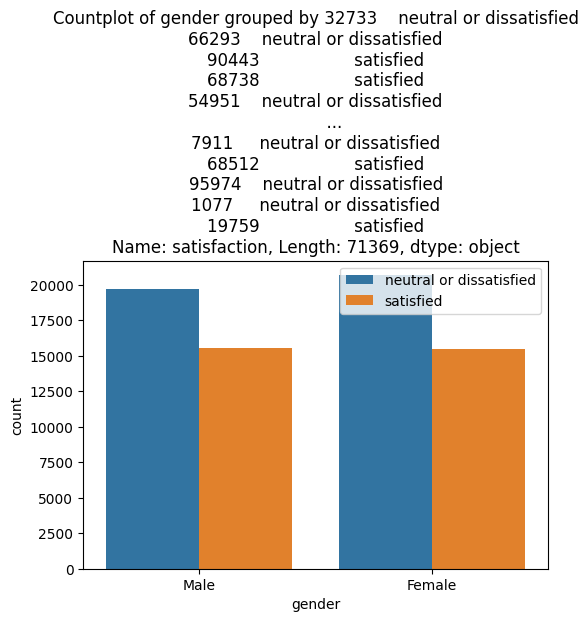

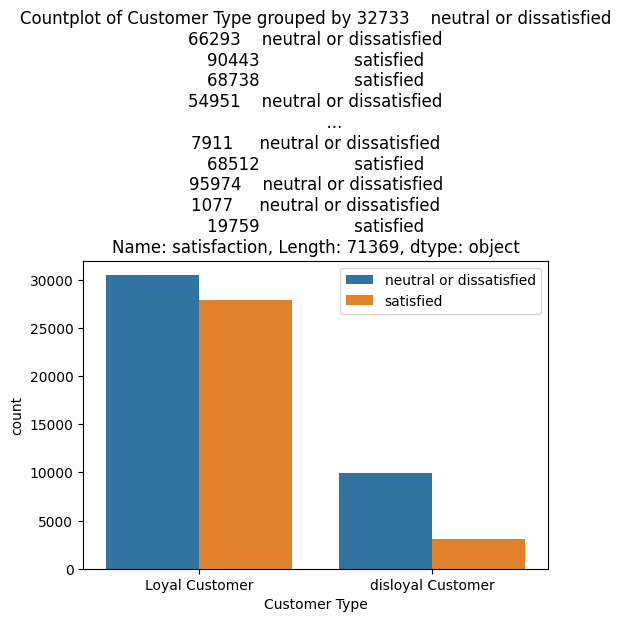

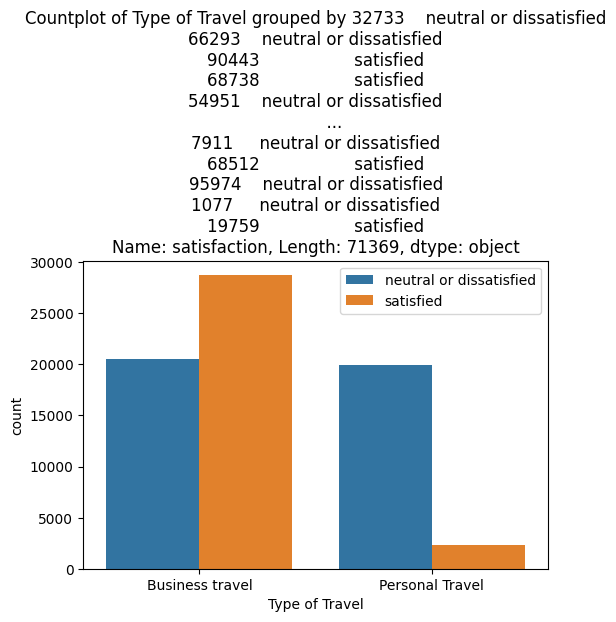

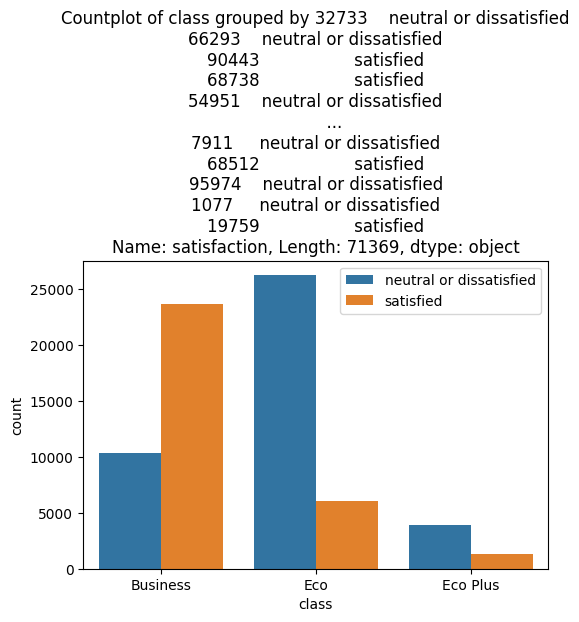

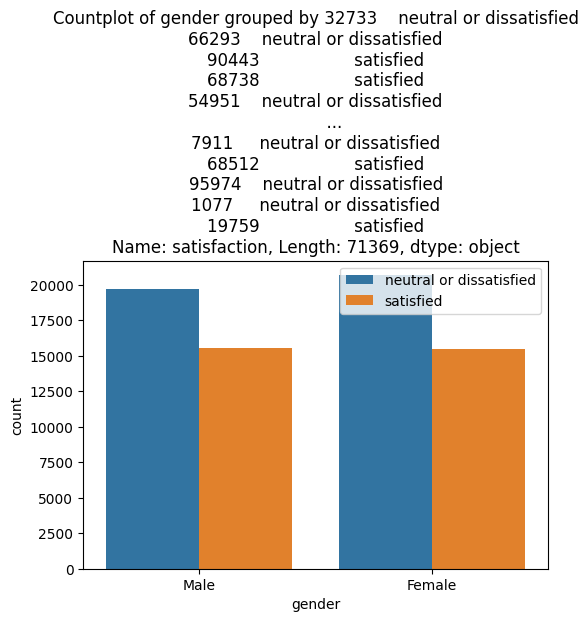

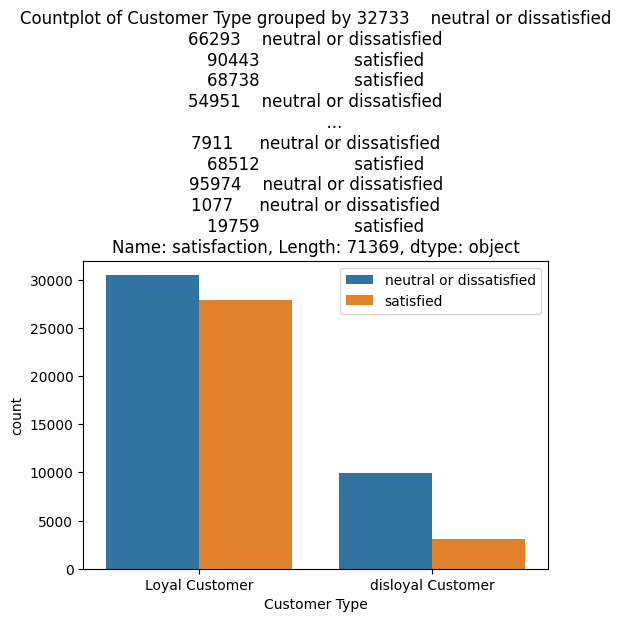

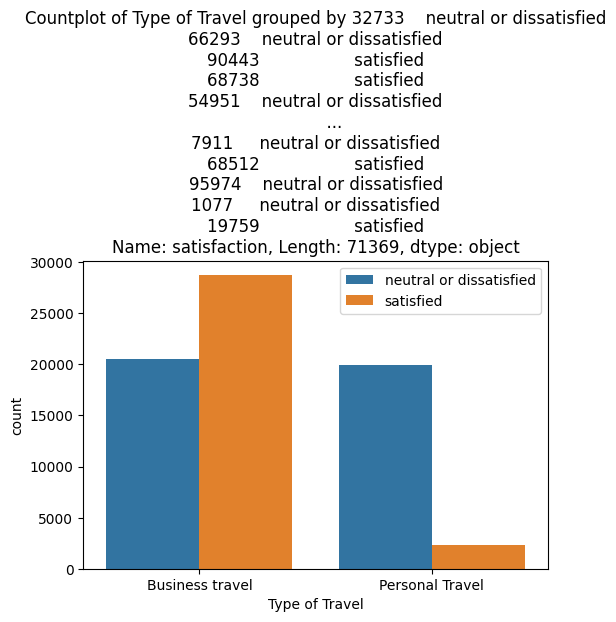

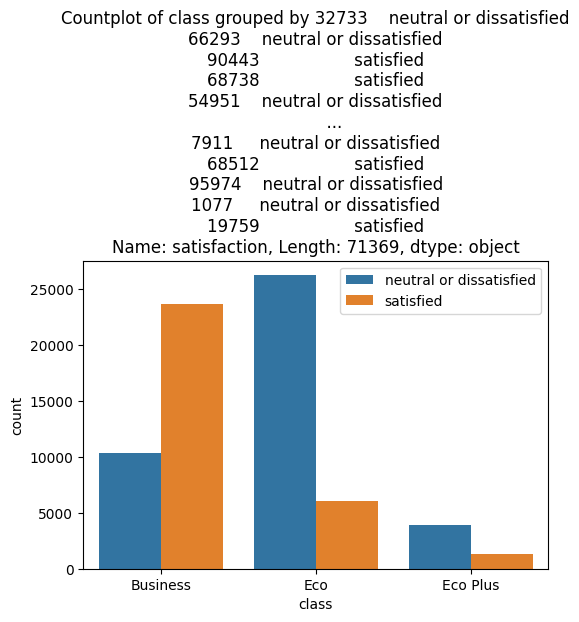

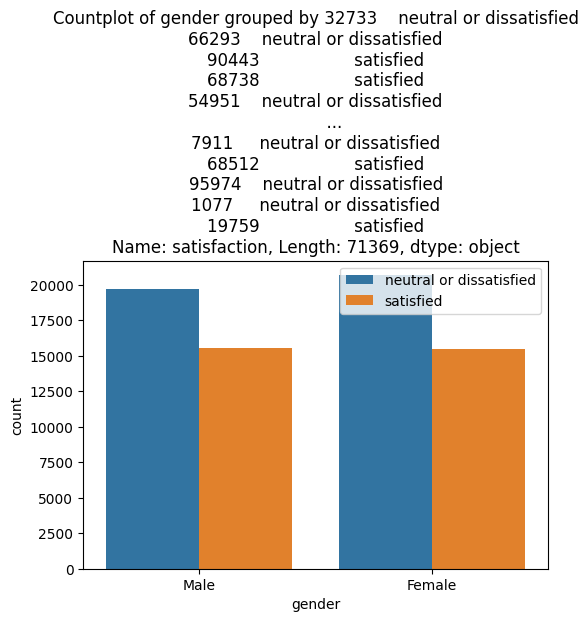

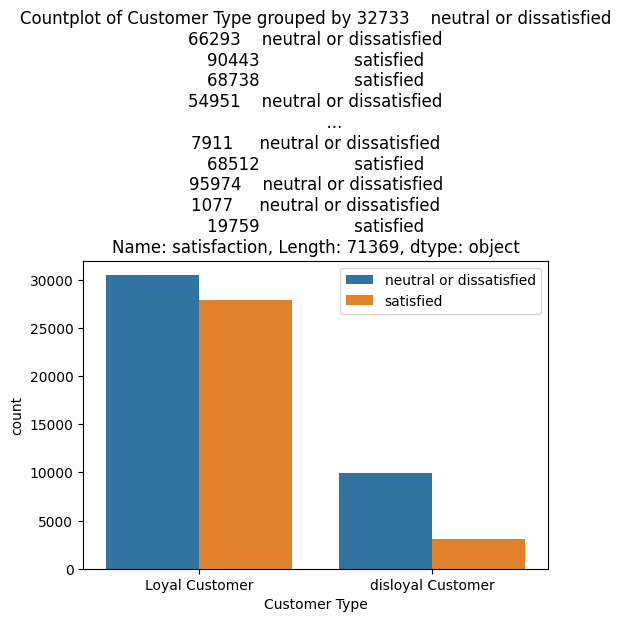

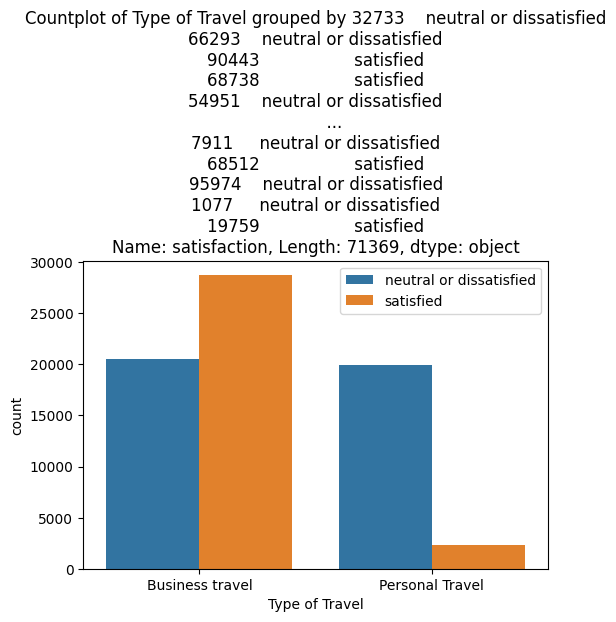

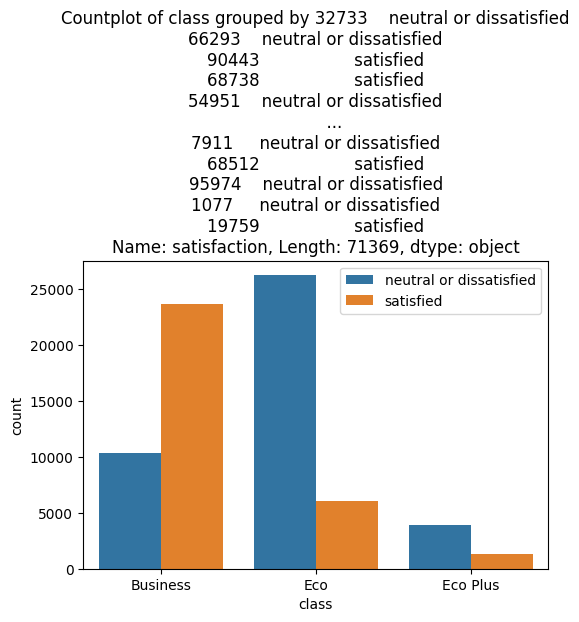

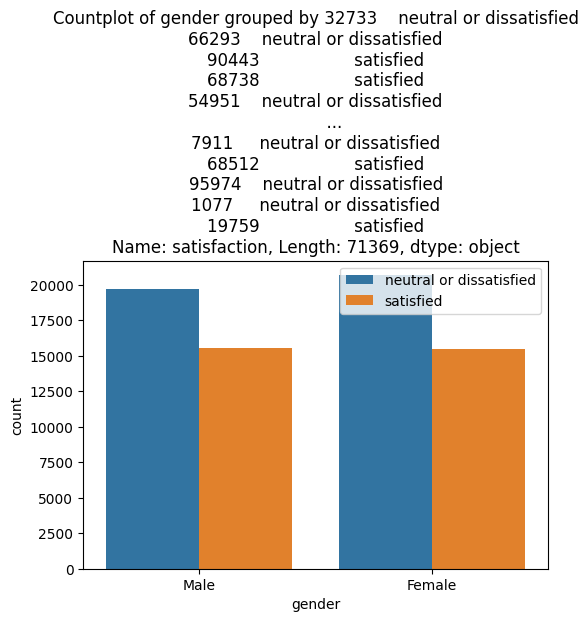

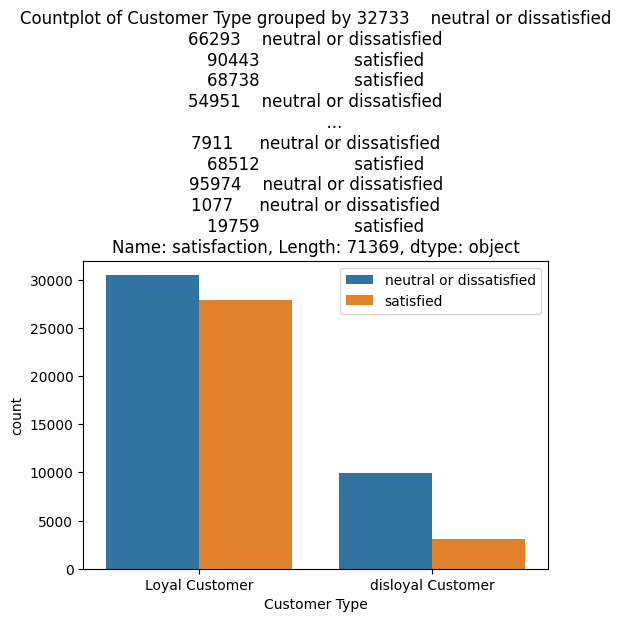

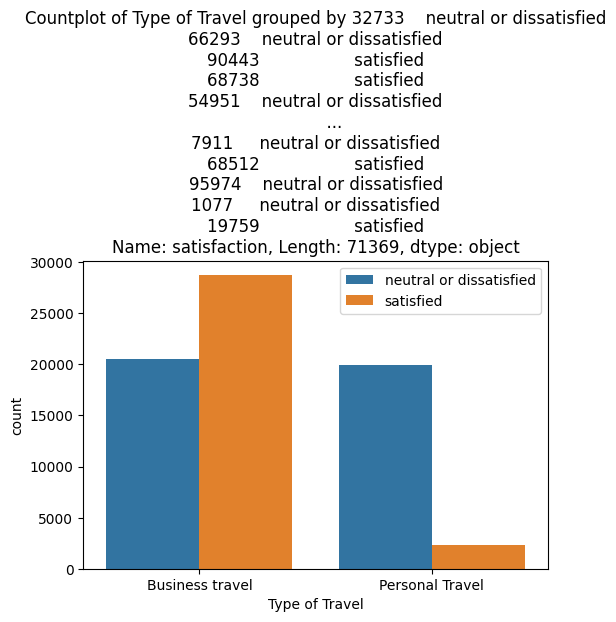

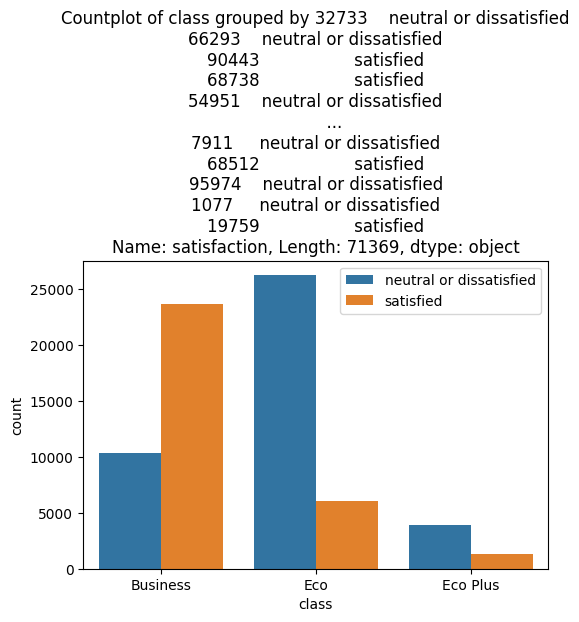

In [38]:
plot_categorical(categorical_cols, X_train, y_train_new)

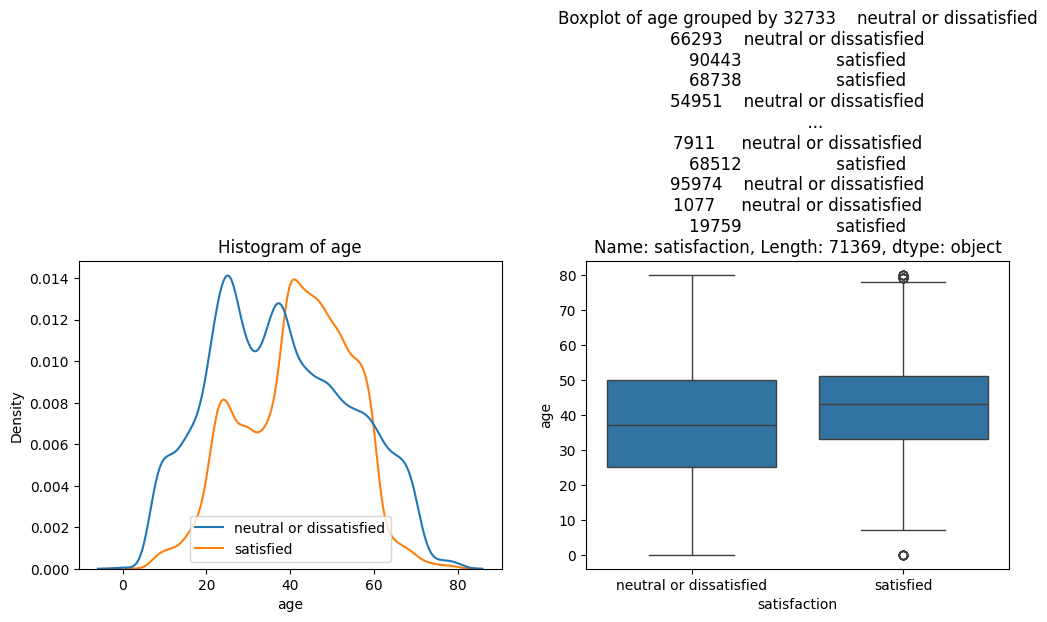

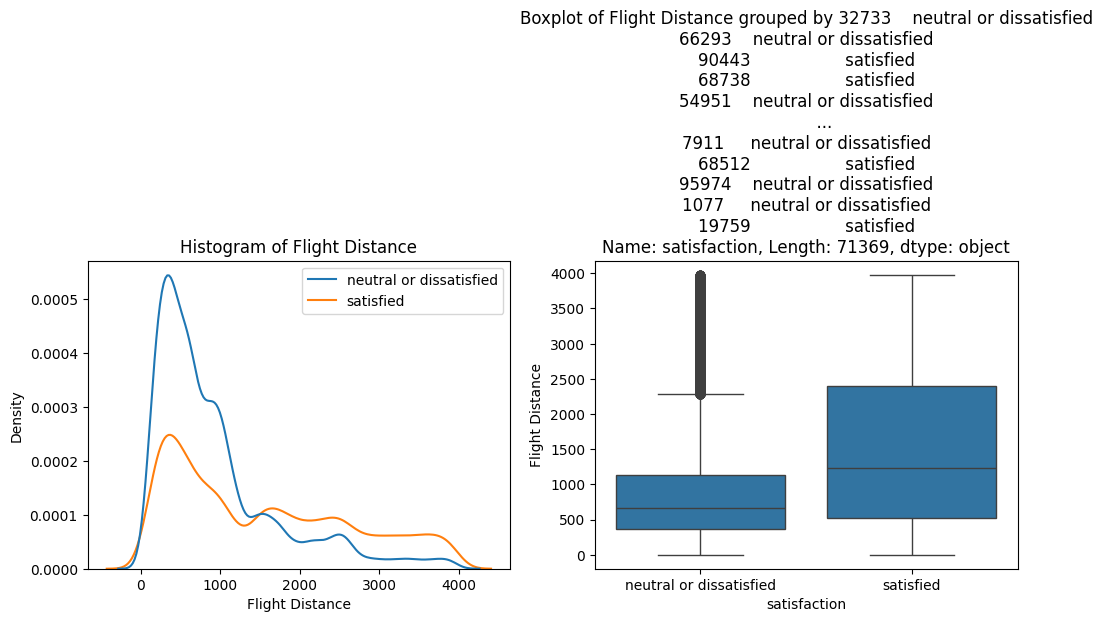

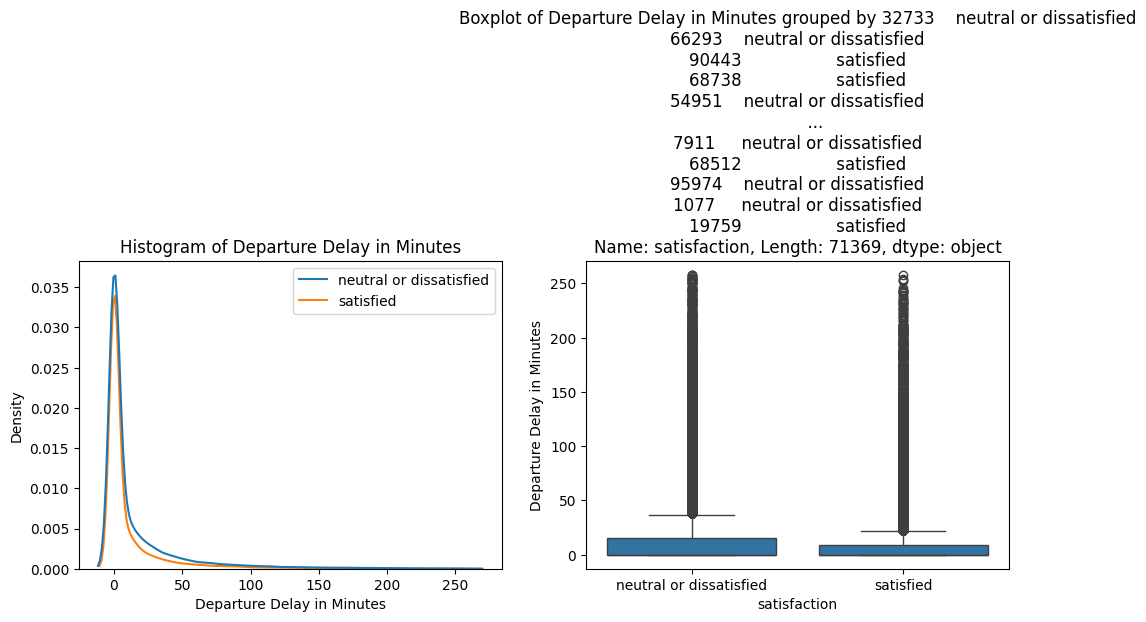

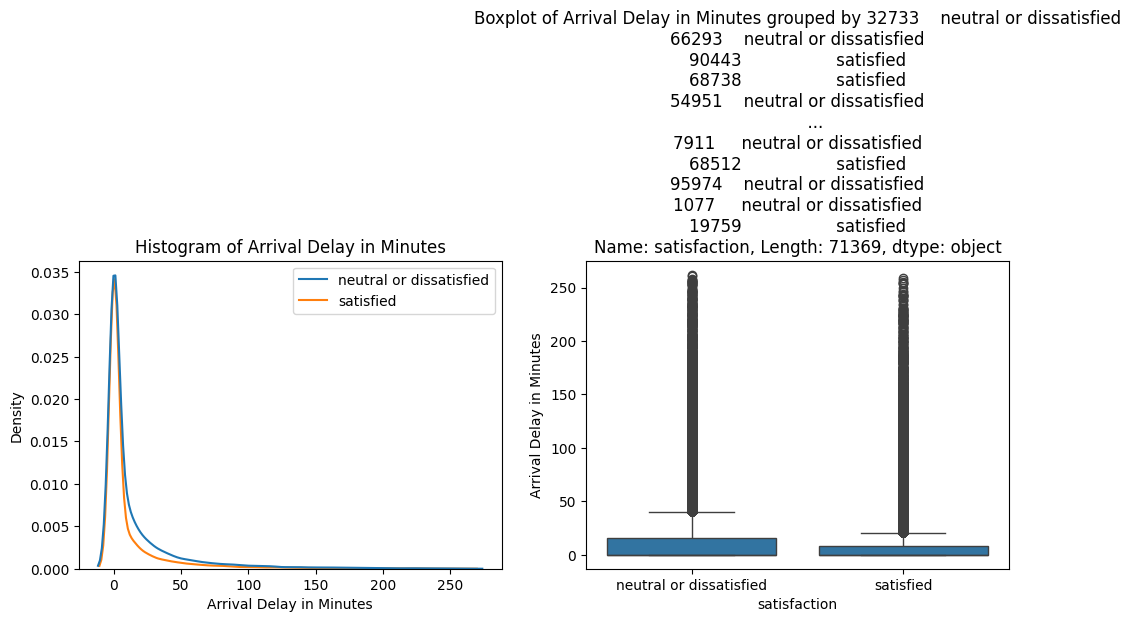

In [39]:
plot_continuous(continuous_cols, X_train_1, y_train_new)

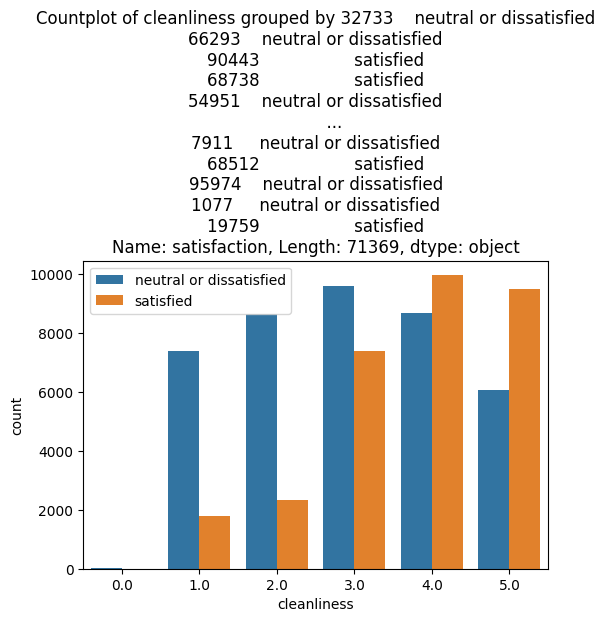

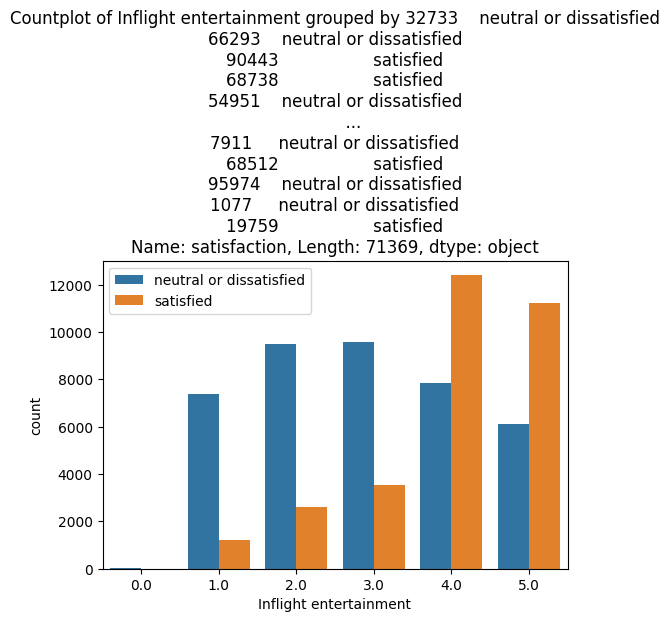

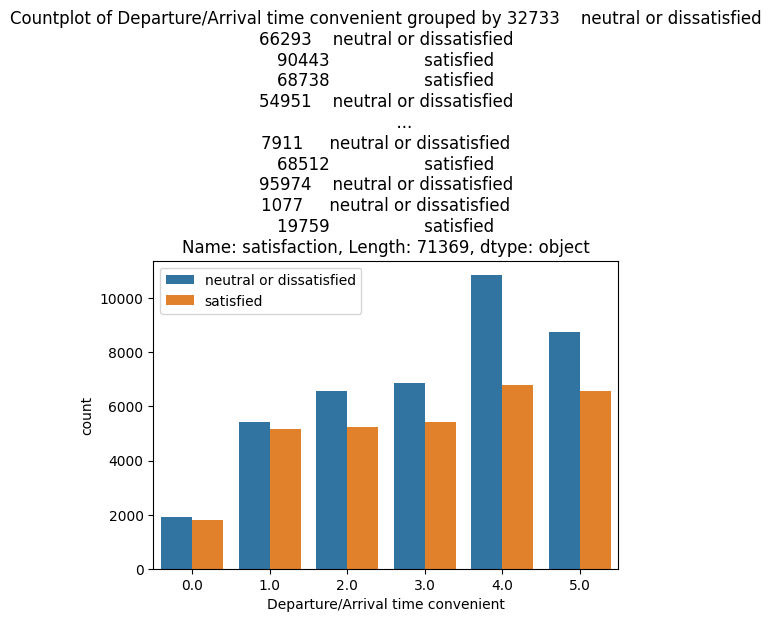

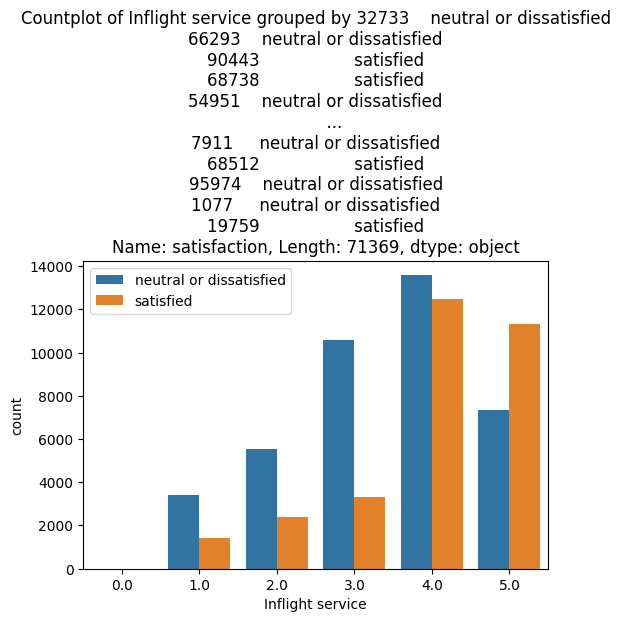

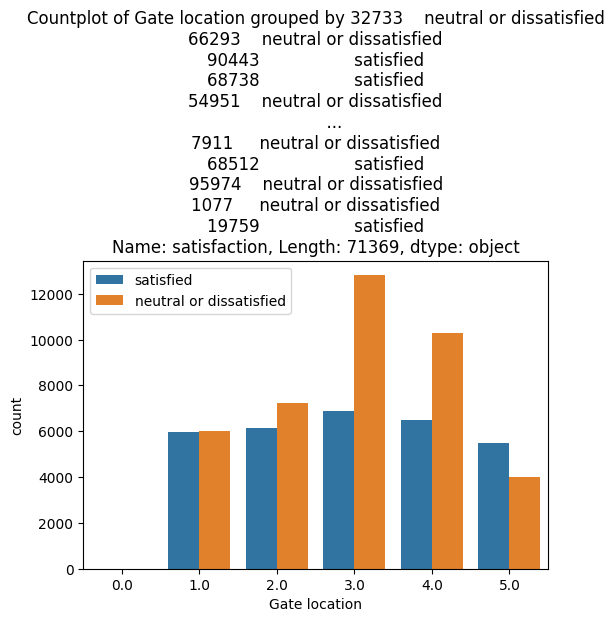

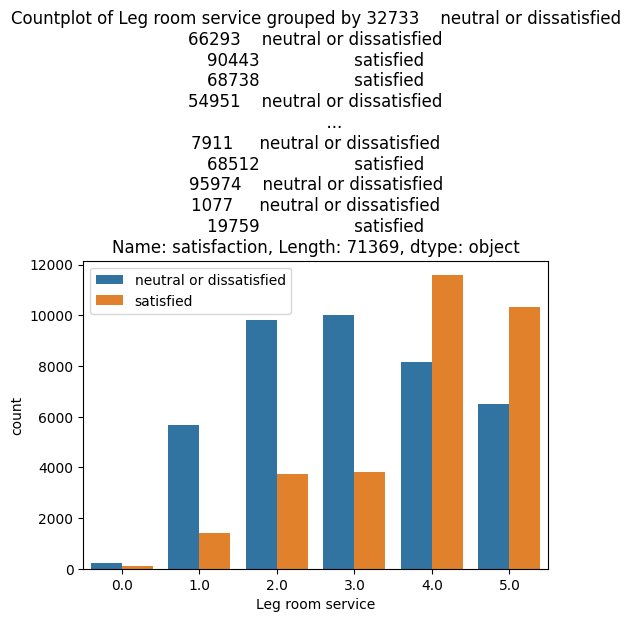

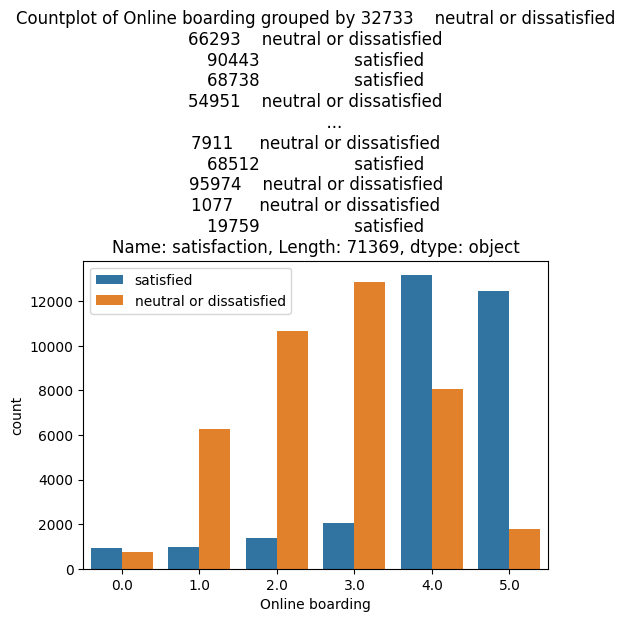

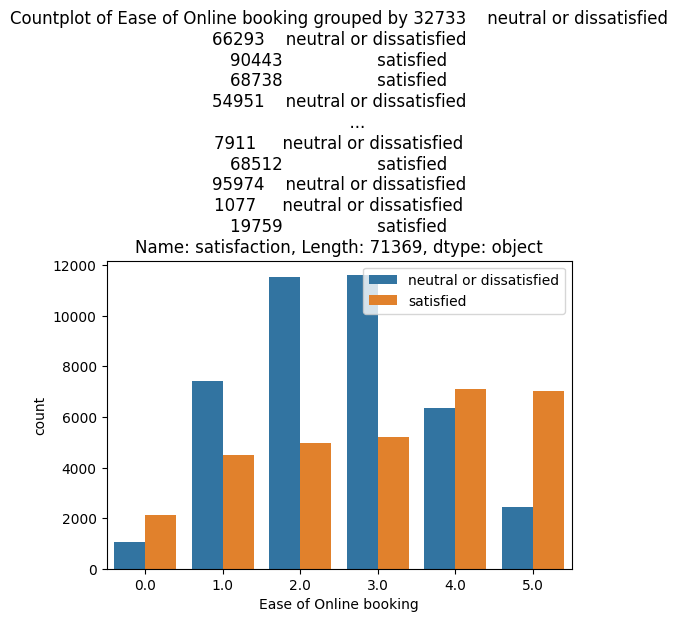

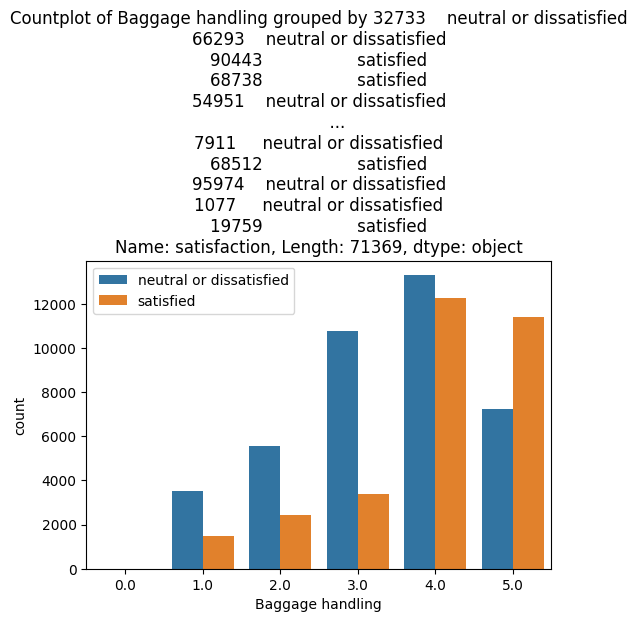

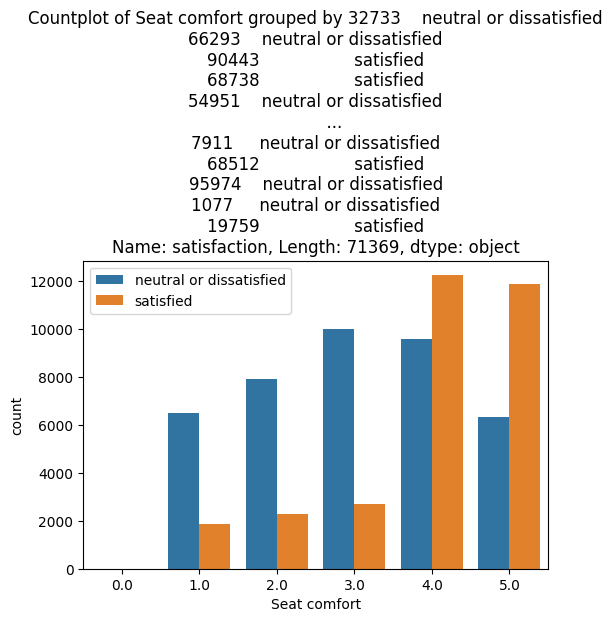

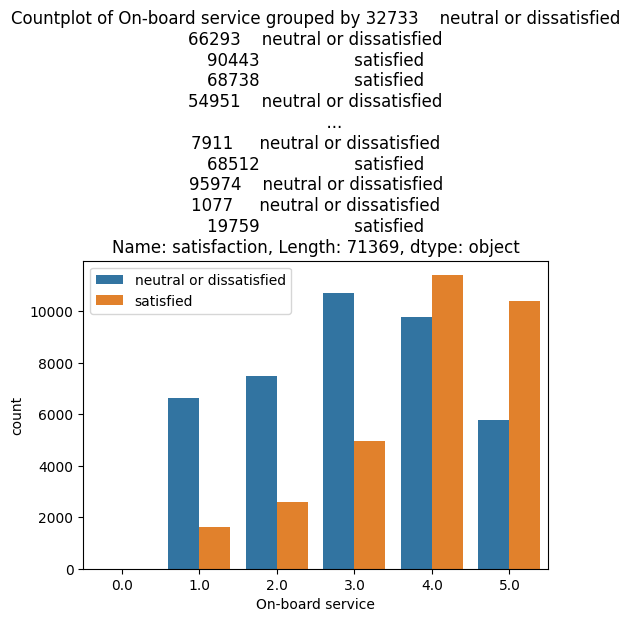

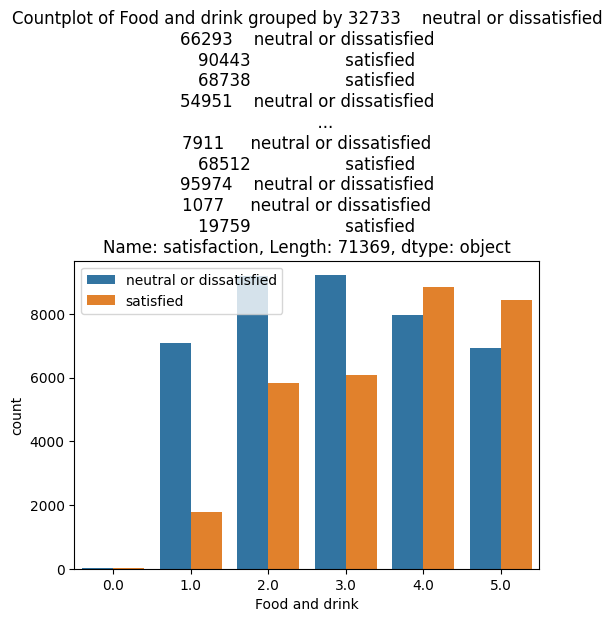

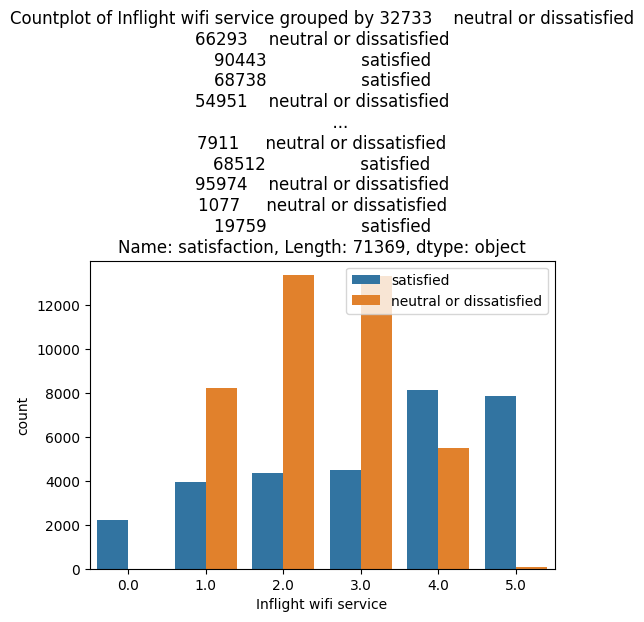

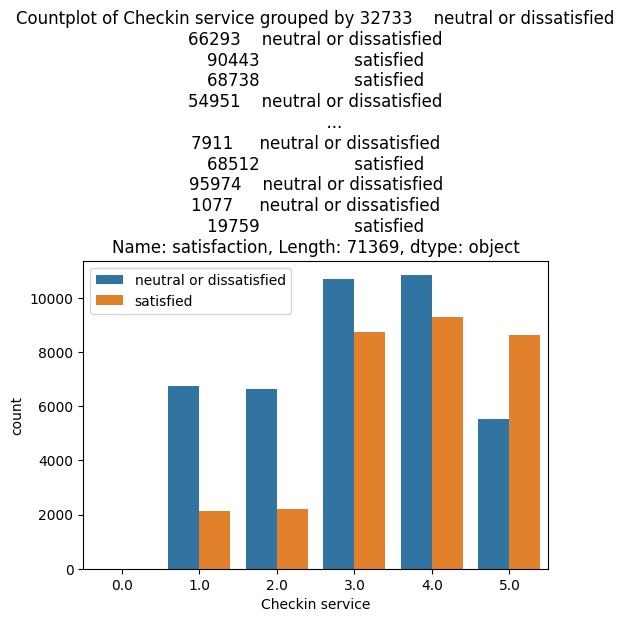

In [40]:
plot_ordinal(ordinal_cols, X_train, y_train_new)

<Axes: ylabel='count'>

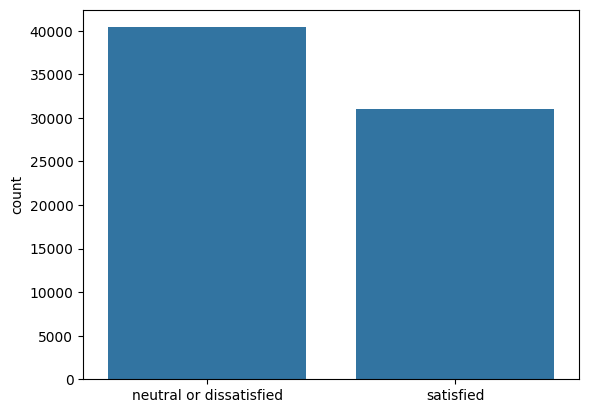

In [41]:
sns.countplot(x=y_train_new.values)

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

In [42]:
# your answer her
# feel free to change this cell from code to markdown

**Неравномерное распределение признаков:**

Например, Customer Type преобладает значение Loyal Customer, что указывает на неравномерное распределение. Аналогично, в Type of Travel преобладает Business travel.

Такие неравномерные распределения могут влиять на модель машинного обучения, предвзято отдавая предпочтение более частым категориям.


**Сбалансированность классов:**

Классы выглядят сбалансированными. Это хороший знак для обучения модели, так как дисбаланс классов может привести к смещению в пользу более частого класса

**Распределения континуальных признаков:**

age - cредний возраст составляет около 39 лет со стандартным отклонением 15 лет, максимальный возраст - 80 лет, что указывает на разнообразие возрастных групп.

Flight Distance: В среднем 1180 км с большим стандартным отклонением (987 км), что указывает на широкий диапазон значений.

Departure Delay in Minutes и Arrival Delay in Minutes - имеют среднее значение около 13-14 минут, но с большим стандартным отклонением, что может указывать на некоторые значительные задержки.

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [43]:
from sklearn.compose import make_column_transformer

cols = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
tr = make_column_transformer((FunctionTransformer(np.log1p, validate=True), cols))
X_train[cols] = tr.fit_transform(X_train)

df_test[cols] = tr.transform(df_test)
X_val[cols] = tr.transform(X_val)

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

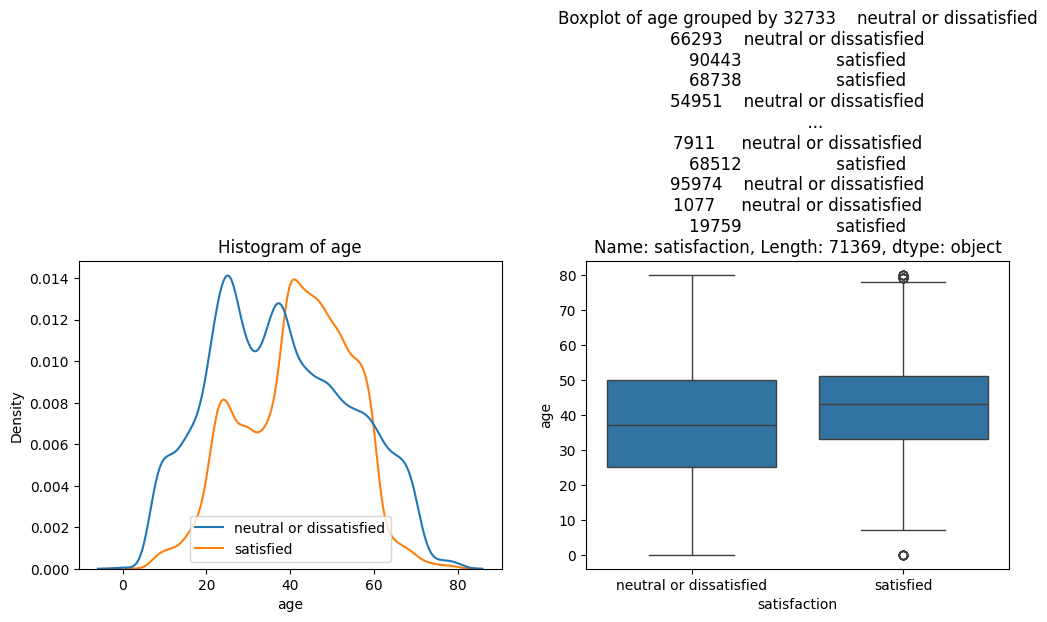

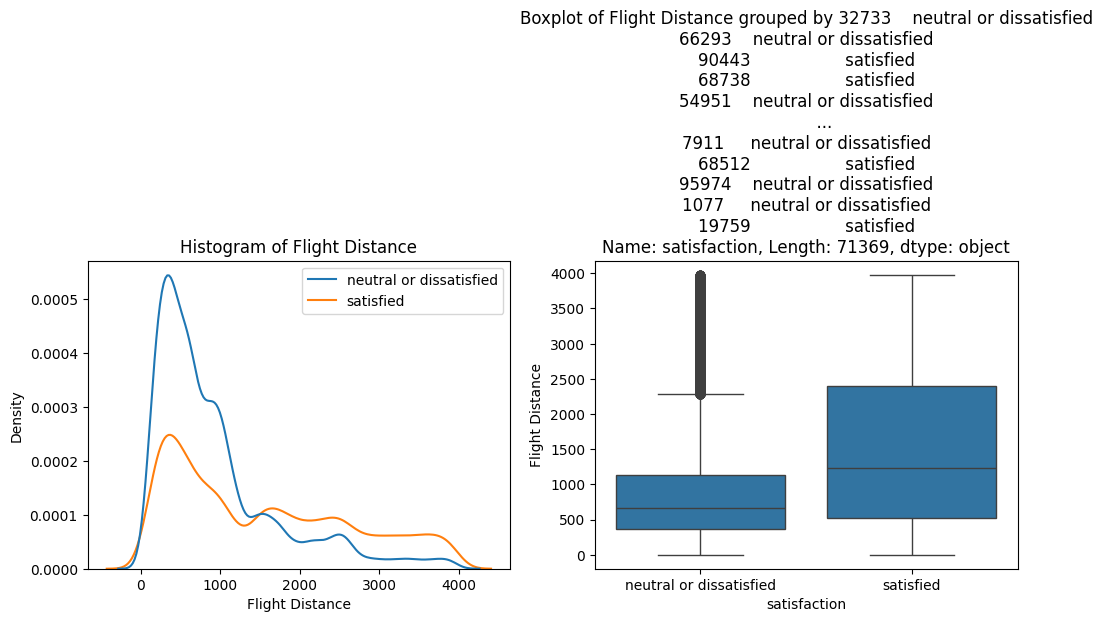

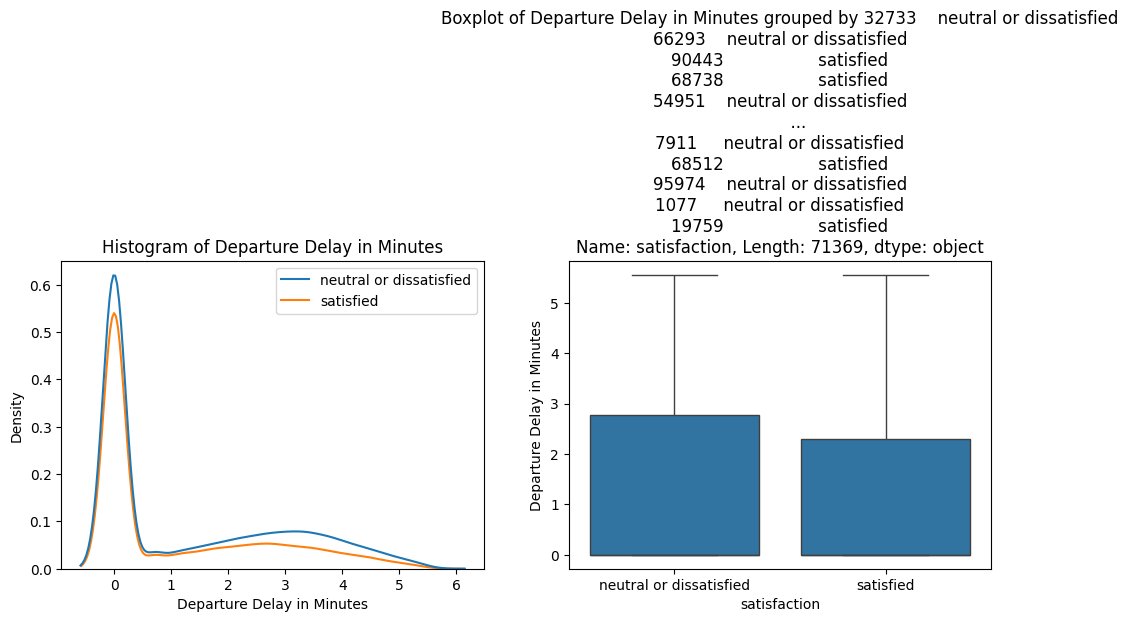

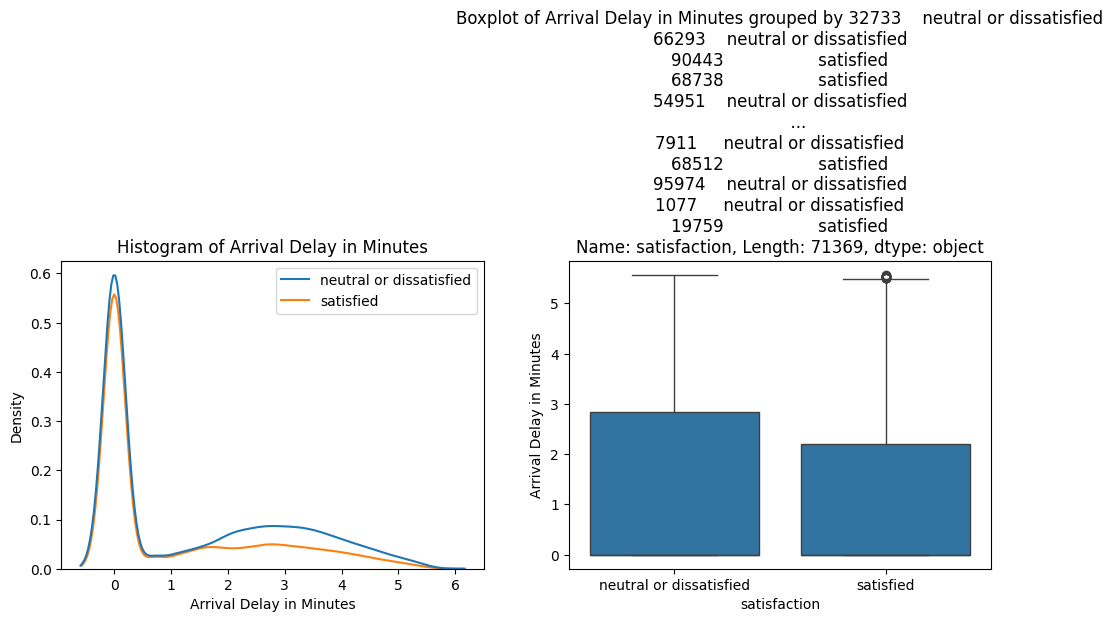

In [44]:
plot_continuous(continuous_cols, X_train, y_train_new)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [45]:
y_train_enc = y_train_new.map({'satisfied': 1, 'neutral or dissatisfied': 0})
y_val_enc = y_val_new.map({'satisfied': 1, 'neutral or dissatisfied': 0})

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

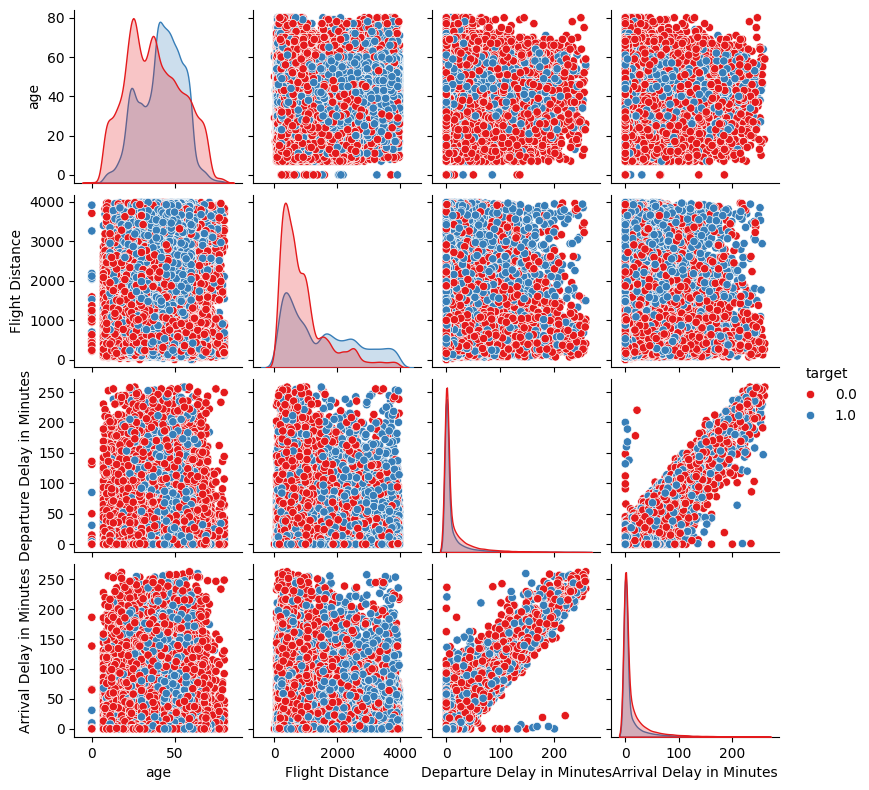

In [48]:
data_plot = X_train.copy()
data_plot['target'] = y_train_enc
sns.pairplot(data_plot, vars=continuous_cols, hue='target', palette='Set1', height=2)
plt.show()

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [49]:
X_train=pd.get_dummies(X_train, columns = categorical_cols, drop_first = True)
X_val=pd.get_dummies(X_val, columns = categorical_cols, drop_first = True)
df_test=pd.get_dummies(df_test, columns = categorical_cols, drop_first = True)

In [50]:
y_train_n = y_train_enc.loc[X_train.index]
y_val_n = y_val_enc.loc[X_val.index]

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [51]:
dt = DecisionTreeClassifier(random_state = 42)

dt.fit(X_train, y_train_n)

DecisionTreeClassifier(random_state=42)

In [52]:
pred = dt.predict(X_val)
accuracy_score(y_val_n, pred)

0.9430551469386421

## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [53]:
error_dt, bias_dt, var_dt = bias_variance_decomp(dt, X_train.values, y_train_n.values, X_val.values, y_val_n.values, loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.060544931515805304, 0.03975025334248635, 0.044407178581935866)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [54]:
dt.feature_importances_

array([0.0201057 , 0.02939299, 0.00784477, 0.01063025, 0.17646719,
       0.00759819, 0.0045412 , 0.01412106, 0.00373869, 0.36276247,
       0.01670953, 0.04587929, 0.00835967, 0.02039902, 0.01353451,
       0.02800739, 0.01576731, 0.00964622, 0.0028662 , 0.02878352,
       0.15498448, 0.01530325, 0.00255708])



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



<Axes: ylabel='None'>

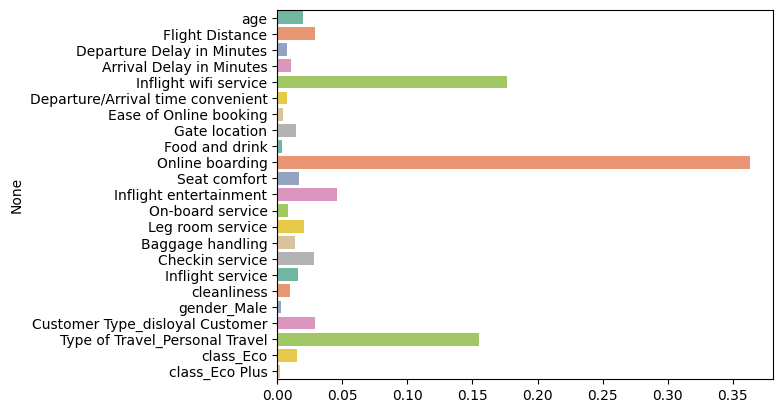

In [55]:
sns.barplot(x=dt.feature_importances_, y=X_train.columns, palette='Set2')

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

3 самых информативных признаокв
- Online boarding
- Inflight wifi service
- Type of Travel_Personal Travel

In [56]:
feats = dt.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feats})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                              Feature  Importance
9                     Online boarding    0.362762
4               Inflight wifi service    0.176467
20     Type of Travel_Personal Travel    0.154984
11             Inflight entertainment    0.045879
1                     Flight Distance    0.029393
19    Customer Type_disloyal Customer    0.028784
15                    Checkin service    0.028007
13                   Leg room service    0.020399
0                                 age    0.020106
10                       Seat comfort    0.016710
16                   Inflight service    0.015767
21                          class_Eco    0.015303
7                       Gate location    0.014121
14                   Baggage handling    0.013535
3            Arrival Delay in Minutes    0.010630
17                        cleanliness    0.009646
12                   On-board service    0.008360
2          Departure Delay in Minutes    0.007845
5   Departure/Arrival time convenient    0.007598


<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [57]:
dt.get_depth(), dt.get_n_leaves()

(30, 2099)

<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [58]:
dt2 = DecisionTreeClassifier(max_depth=5,random_state = 42)

dt2.fit(pd.DataFrame(X_train, columns=['Inflight wifi service','Online boarding']), y_train_n)

pred = dt2.predict(pd.DataFrame(X_val, columns=['Inflight wifi service','Online boarding']))
accuracy_score(y_val_n, pred)

0.8217776470203655

Качество упало примерно на 0.12

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

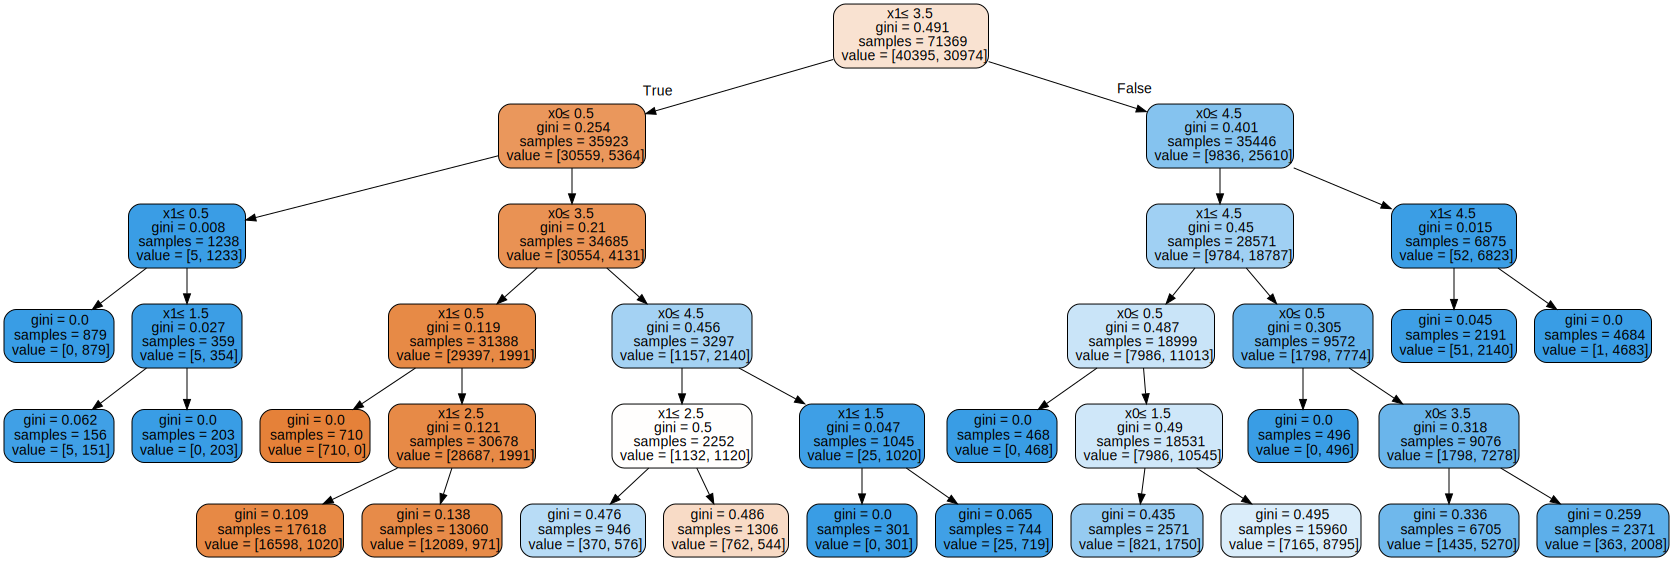

In [59]:
dot_data = export_graphviz(dt2, out_file=None, filled=True, rounded=True, special_characters=True)

graph = Source(dot_data)
SVG(graph.pipe(format='svg'))

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [60]:
dt3 = DecisionTreeClassifier(max_depth=5,random_state=42)

X_train_new = X_train[['age','Flight Distance']].copy()
X_val_new = X_val[['age','Flight Distance']].copy()

dt3.fit(X_train_new, y_train_n)

pred = dt3.predict(X_val_new)
accuracy_score(y_val_n,pred)

0.6809519139616227

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

Получилось симметричным. Симметричное дерево, особенно с большой глубиной, может быть признаком переобучения

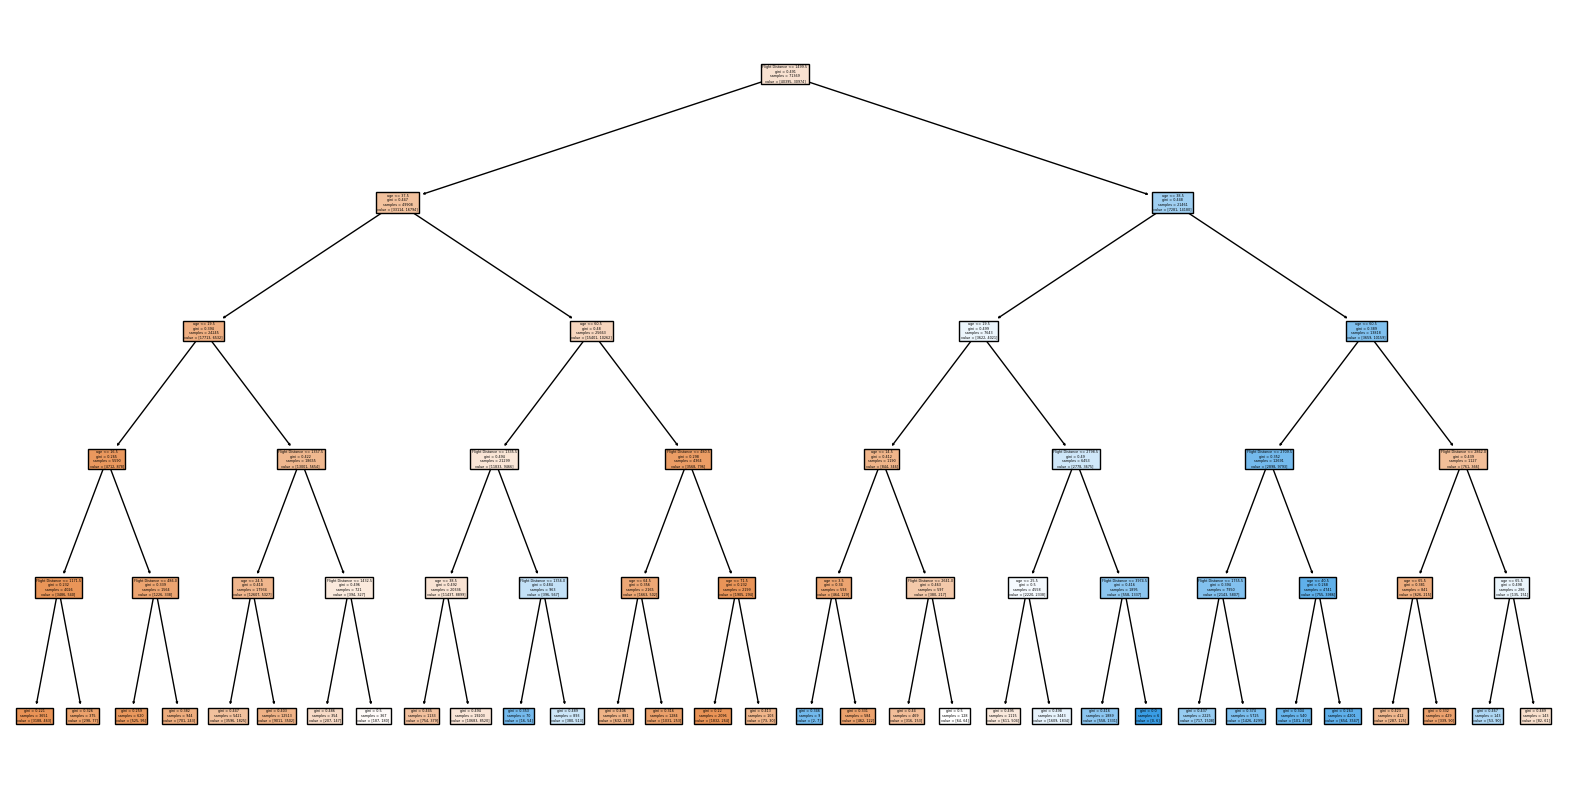

In [61]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(dt3, filled=True, feature_names=['age', 'Flight Distance'])
plt.show()


(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


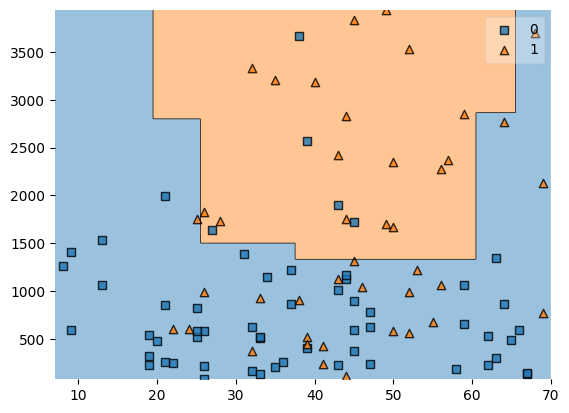

In [62]:
plot_decision_regions(X_train_new[:100].values, y_train_n.values[:100], clf = dt3)

plt.show()

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


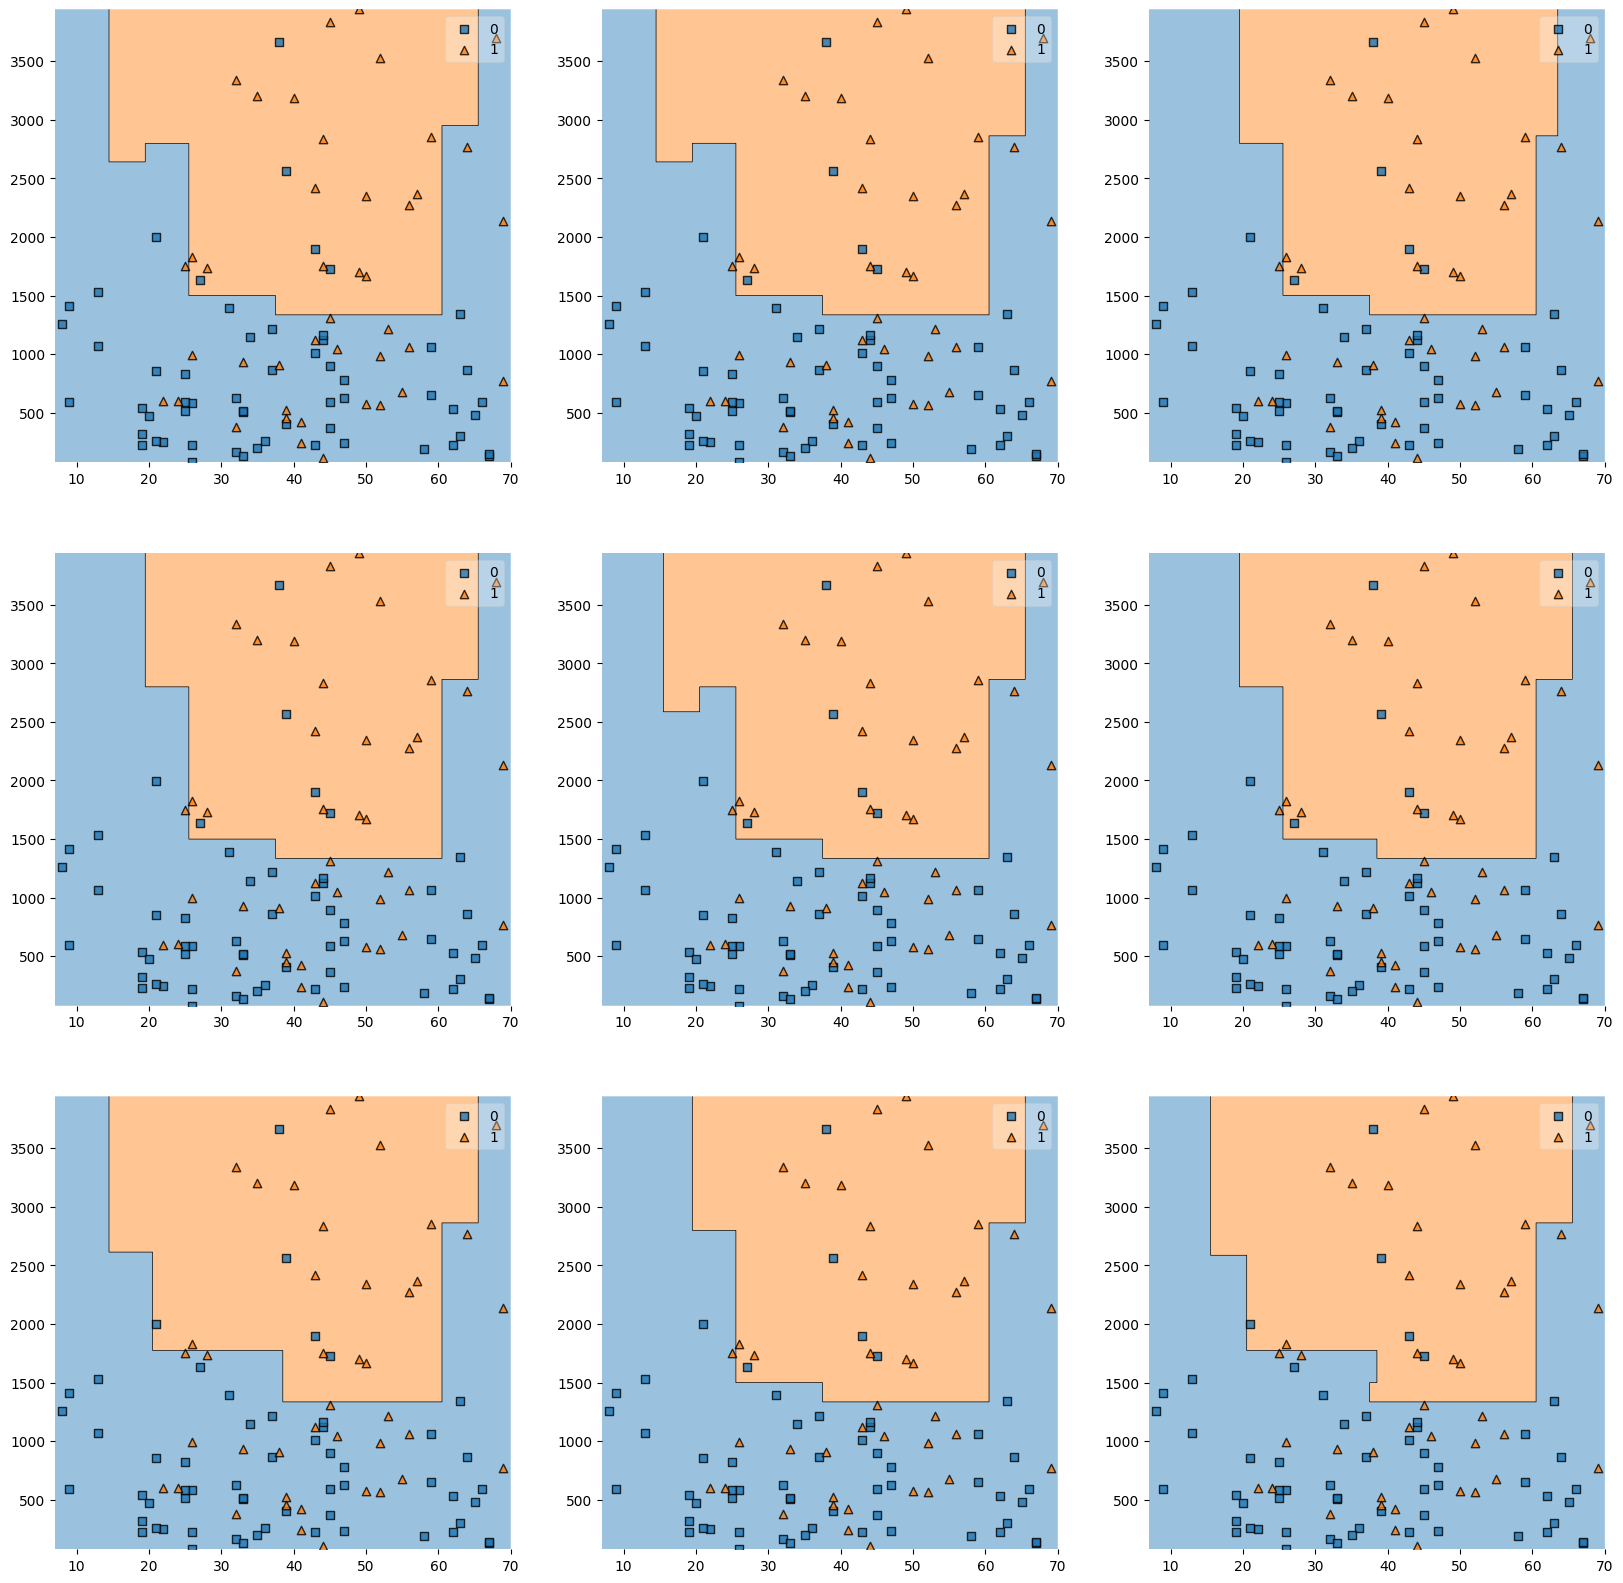

In [63]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_new.index, size=X_train_new.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_new.loc[inds, :], y_train_n[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_new.iloc[:100, :]), y=np.array(y_train_n[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [64]:
%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train_n)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train_n, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val_n, y_predicted_val))

CPU times: user 6.34 s, sys: 14 ms, total: 6.36 s
Wall time: 6.42 s


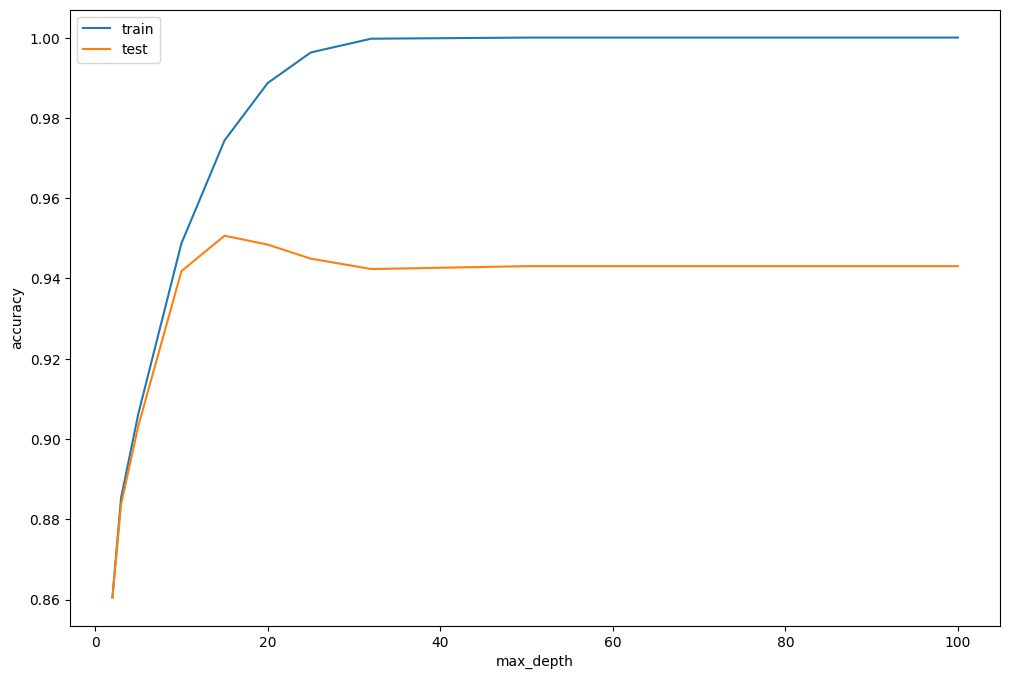

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [66]:
params = {
    'max_depth': np.arange(10, 100, 5),
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2']
}

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=15, cv=3, scoring='roc_auc', verbose=2)
dt_gs.fit(X_train, y_train_n)
dt_gs.best_estimator_, dt_gs.best_score_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


(DecisionTreeClassifier(max_depth=10, max_features='sqrt', random_state=42),
 0.9518358853410436)

In [67]:
dt_fin = dt_gs.best_estimator_
y_pred = dt_fin.predict(X_val)
accuracy_score(y_val_n, y_pred)

0.9121310189271354

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [68]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(dt_fin, f)

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [69]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train_n)

y_pred = rf.predict(X_val)
accuracy_score(y_val_n, y_pred)

0.9600209211859697

(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

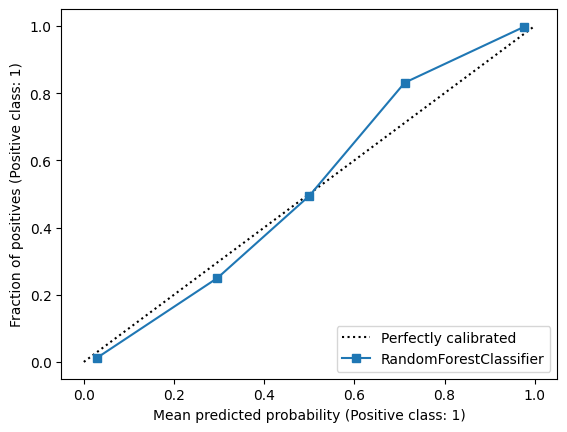

In [70]:
CalibrationDisplay.from_estimator(rf, X_val, y_val_n)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

Деревья решений могут предсказывать вероятности, но эта способность может быть ограничена, особенно при использовании простых деревьев.

Часто приходится делать калибровку вероятности

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [71]:
params = {'C': np.arange(0,5,1), 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

lr = GridSearchCV(LogisticRegression(random_state=42), params, cv=3, scoring='roc_auc', verbose=2)
lr.fit(X_train, y_train_n)
lr.best_estimator_, lr.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ..................................C=0, solver=lbfgs; total time=   0.0s
[CV] END ..................................C=0, solver=lbfgs; total time=   0.0s
[CV] END ..................................C=0, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0, solver=newton-cg; total time=   0.0s
[CV] END ..............................C=0, solver=newton-cg; total time=   0.0s
[CV] END ..............................C=0, solver=newton-cg; total time=   0.0s
[CV] END ........................C=0, solver=newton-cholesky; total time=   0.0s
[CV] END ........................C=0, solver=newton-cholesky; total time=   0.0s
[CV] END ........................C=0, solver=new

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, solver=lbfgs; total time=   0.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, solver=lbfgs; total time=   1.1s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, solver=lbfgs; total time=   1.3s
[CV] END ..............................C=1, solver=liblinear; total time=   1.2s
[CV] END ..............................C=1, solver=liblinear; total time=   1.1s
[CV] END ..............................C=1, solver=liblinear; total time=   1.2s
[CV] END ..............................C=1, solver=newton-cg; total time=   1.9s
[CV] END ..............................C=1, solver=newton-cg; total time=   1.7s
[CV] END ..............................C=1, solver=newton-cg; total time=   1.5s
[CV] END ........................C=1, solver=newton-cholesky; total time=   0.2s
[CV] END ........................C=1, solver=newton-cholesky; total time=   0.1s
[CV] END ........................C=1, solver=newton-cholesky; total time=   0.1s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=1, solver=sag; total time=   2.5s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=1, solver=sag; total time=   2.5s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=1, solver=sag; total time=   3.7s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=1, solver=saga; total time=   3.3s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=1, solver=saga; total time=   2.6s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=1, solver=saga; total time=   2.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=2, solver=lbfgs; total time=   0.6s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=2, solver=lbfgs; total time=   0.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=2, solver=lbfgs; total time=   0.6s
[CV] END ..............................C=2, solver=liblinear; total time=   0.7s
[CV] END ..............................C=2, solver=liblinear; total time=   1.1s
[CV] END ..............................C=2, solver=liblinear; total time=   1.1s
[CV] END ..............................C=2, solver=newton-cg; total time=   3.3s
[CV] END ..............................C=2, solver=newton-cg; total time=   2.6s
[CV] END ..............................C=2, solver=newton-cg; total time=   1.7s
[CV] END ........................C=2, solver=newton-cholesky; total time=   0.1s
[CV] END ........................C=2, solver=newton-cholesky; total time=   0.2s
[CV] END ........................C=2, solver=newton-cholesky; total time=   0.1s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=2, solver=sag; total time=   2.9s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=2, solver=sag; total time=   3.0s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=2, solver=sag; total time=   3.9s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=2, solver=saga; total time=   3.8s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=2, solver=saga; total time=   3.2s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=2, solver=saga; total time=   2.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=3, solver=lbfgs; total time=   0.6s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=3, solver=lbfgs; total time=   0.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=3, solver=lbfgs; total time=   0.7s
[CV] END ..............................C=3, solver=liblinear; total time=   1.1s
[CV] END ..............................C=3, solver=liblinear; total time=   1.2s
[CV] END ..............................C=3, solver=liblinear; total time=   1.1s
[CV] END ..............................C=3, solver=newton-cg; total time=   3.7s
[CV] END ..............................C=3, solver=newton-cg; total time=   1.8s
[CV] END ..............................C=3, solver=newton-cg; total time=   1.6s
[CV] END ........................C=3, solver=newton-cholesky; total time=   0.1s
[CV] END ........................C=3, solver=newton-cholesky; total time=   0.1s
[CV] END ........................C=3, solver=newton-cholesky; total time=   0.1s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=3, solver=sag; total time=   2.6s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=3, solver=sag; total time=   2.5s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=3, solver=sag; total time=   3.3s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=3, solver=saga; total time=   3.7s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=3, solver=saga; total time=   3.7s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=3, solver=saga; total time=   3.3s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=4, solver=lbfgs; total time=   0.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=4, solver=lbfgs; total time=   0.6s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=4, solver=lbfgs; total time=   0.7s
[CV] END ..............................C=4, solver=liblinear; total time=   1.1s
[CV] END ..............................C=4, solver=liblinear; total time=   1.2s
[CV] END ..............................C=4, solver=liblinear; total time=   1.2s
[CV] END ..............................C=4, solver=newton-cg; total time=   3.4s
[CV] END ..............................C=4, solver=newton-cg; total time=   1.7s
[CV] END ..............................C=4, solver=newton-cg; total time=   1.5s
[CV] END ........................C=4, solver=newton-cholesky; total time=   0.1s
[CV] END ........................C=4, solver=newton-cholesky; total time=   0.1s
[CV] END ........................C=4, solver=newton-cholesky; total time=   0.1s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=4, solver=sag; total time=   2.5s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=4, solver=sag; total time=   2.5s


The max_iter was reached which means the coef_ did not converge


[CV] END ....................................C=4, solver=sag; total time=   3.2s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=4, solver=saga; total time=   3.9s


The max_iter was reached which means the coef_ did not converge


[CV] END ...................................C=4, solver=saga; total time=   2.7s


The max_iter was reached which means the coef_ did not converge

18 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 97

[CV] END ...................................C=4, solver=saga; total time=   2.7s


(LogisticRegression(C=4, random_state=42, solver='liblinear'),
 0.9281389917353388)

AttributeError: 'CalibrationDisplay' object has no attribute 'plot_calibration_curve'

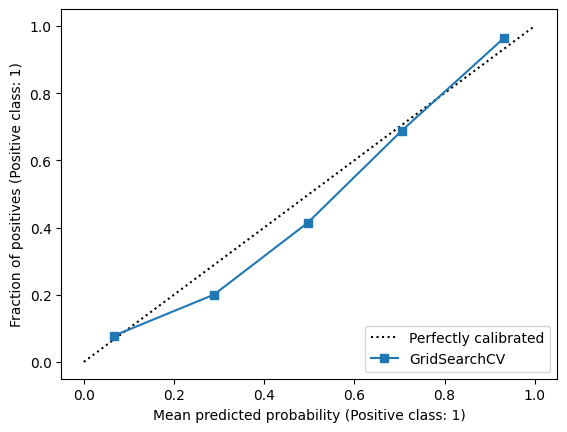

In [72]:
display = CalibrationDisplay.from_estimator(lr, X_val, y_val_n)
display.plot_calibration_curve()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Логистическая регрессия использует логистическую (или сигмоидальную) функцию для преобразования комбинированного входа в вероятность.

Эта функция ограничивает выход в диапазоне от 0 до 1, что соответствует интервалу вероятностей


(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [73]:
from sklearn.calibration import CalibratedClassifierCV

cal_rf = CalibratedClassifierCV(rf, method='sigmoid', cv='prefit')
cal_rf.fit(X_train_1, y_train_n)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(random_state=42))

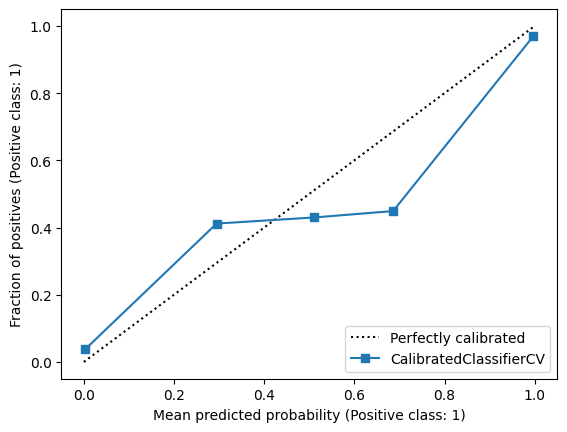

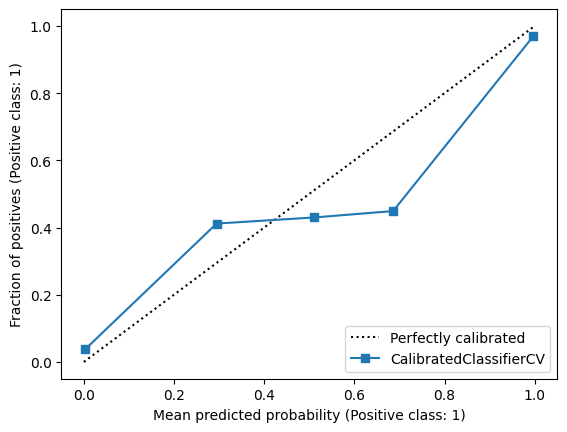

In [74]:
display = CalibrationDisplay.from_estimator(cal_rf, X_val_1, y_val_n)
display.plot()
plt.show()

In [75]:
uncal_proba = rf.predict_proba(X_val_1)[:, 1]

ir = IsotonicRegression()
ir.fit(uncal_proba, y_val_n)

cal_proba = ir.predict(uncal_proba)

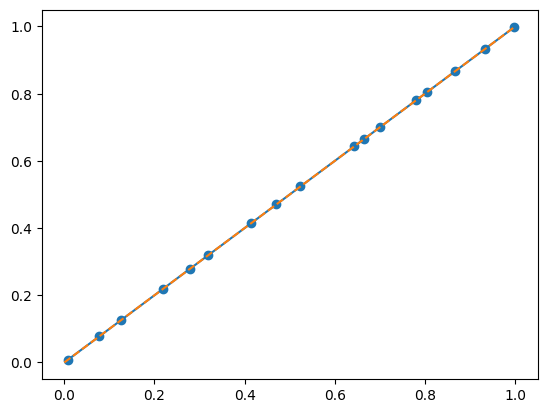

In [76]:
prob_true, prob_pred = calibration_curve(y_val_n, cal_proba, n_bins=20)
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# feel free to change this cell into markdown



(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [77]:
error_dt, bias_dt, var_dt = bias_variance_decomp(rf, X_train_1.values, y_train_n.values, X_val_1.values, y_val_n.values, loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.04165571573338564, 0.039815632048641754, 0.009563924029943447)

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [81]:
error_dt, bias_dt, var_dt = bias_variance_decomp(LogisticRegression(random_state=42, solver='liblinear'), X_train_1.values, y_train_n.values, X_val_1.values, y_val_n.values, loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.12522130692033603, 0.12529829034683404, 0.004427609427609429)

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# your code here



## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [82]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_1[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train_n)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


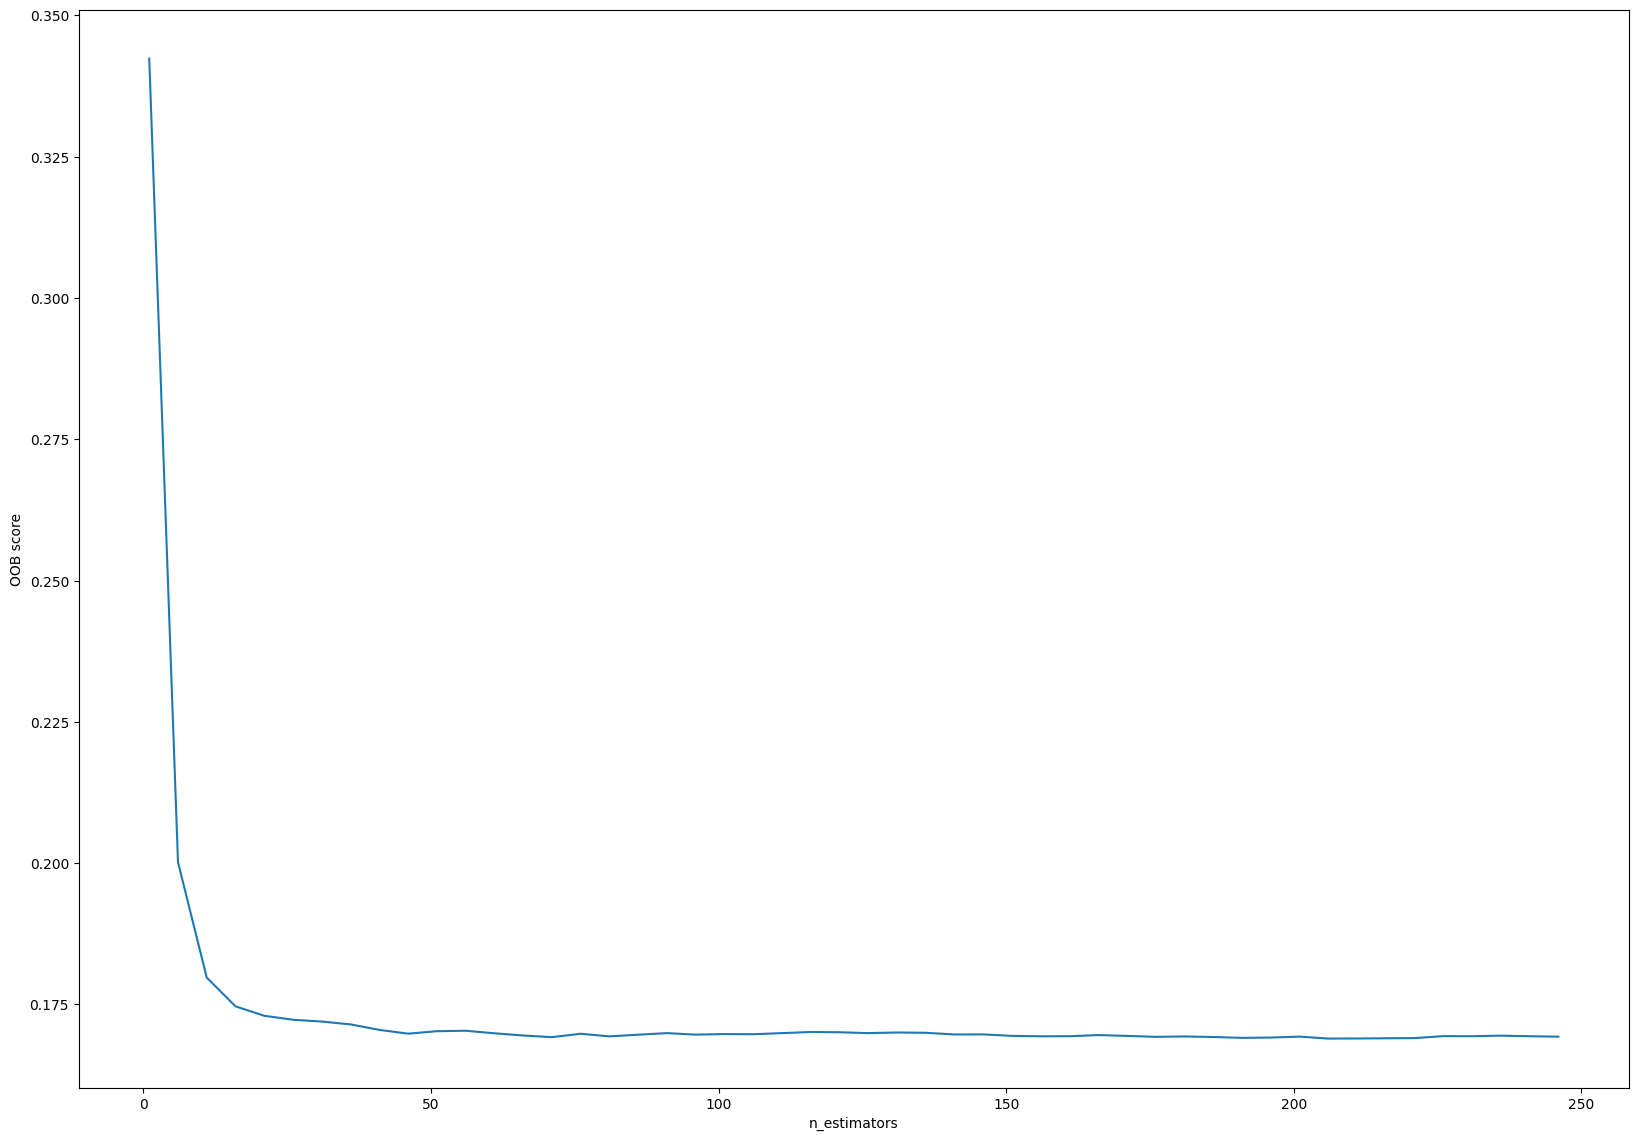

In [83]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



<Axes: ylabel='None'>

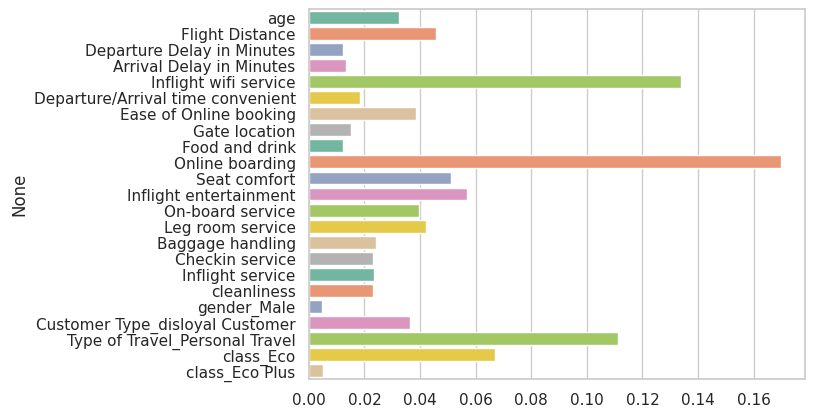

In [86]:
sns.barplot(x=rf.feature_importances_, y=X_train_1.columns, palette='Set2')

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

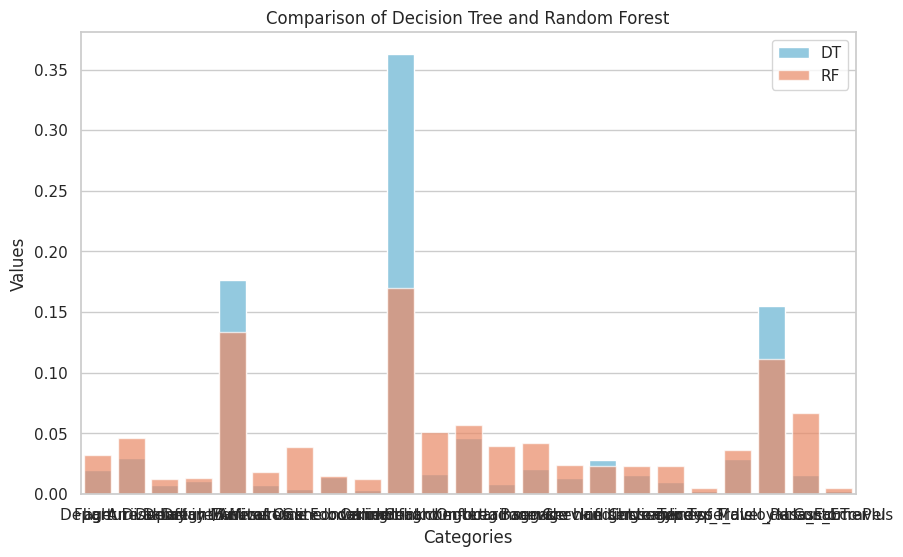

In [87]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x=X_train_1.columns, y=dt.feature_importances_, color='skyblue', label='DT')
sns.barplot(x=X_train_1.columns, y=rf.feature_importances_, color='coral', alpha=0.7, label='RF')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Comparison of Decision Tree and Random Forest')
plt.legend()

# Showing the plot
plt.show()


Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

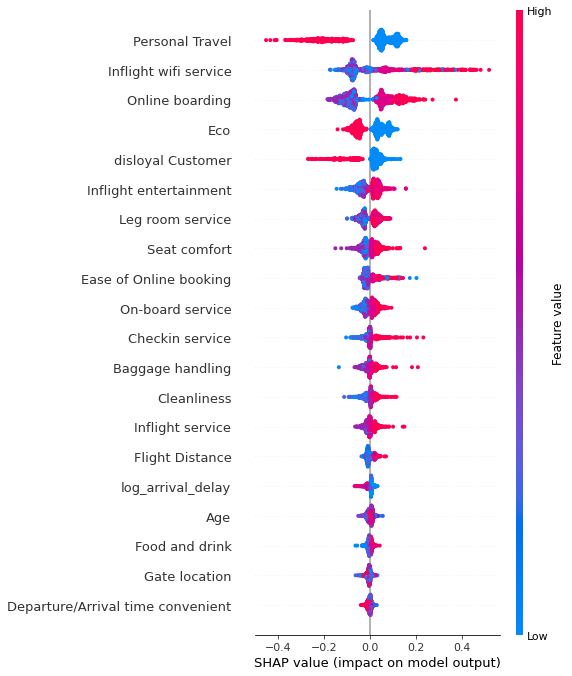

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


In [ ]:
# (•_•)


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown



Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
# please type your solution below



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


CPU times: user 13 s, sys: 918 ms, total: 13.9 s
Wall time: 16.1 s


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?